### This notebook well visualize the Cleaned Datasets 
**Datasets used in this notebook are produced in the data_cleaning notebook**

In [23]:
#importing :
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Loading datasets
items = pd.read_csv("../output/items_cleaned.csv")
orders = pd.read_csv("../output/orders_cleaned.csv")
customers = pd.read_csv("../output/customers_cleaned.csv")

In [25]:
# Standardize column data types for all the datasets
orders = orders.astype({
    "order_id" : str,
    "customer_id" : str,
    "order_status" : str
})
# create a function to speed up the process
def date_time(column) : 
    orders[column] = pd.to_datetime(orders[column])
date_time("order_purchase_timestamp")
date_time("order_approved_at")
date_time("order_delivered_carrier_date")
date_time("order_delivered_customer_date")
date_time("order_estimated_delivery_date")
customers = customers.astype({
    "customer_id" : str,
    "customer_unique_id" : str,
    "customer_zip_code_prefix" : str,
    "customer_city" : str,
    "customer_state" : str
})
items["shipping_limit_date"] = pd.to_datetime(items["shipping_limit_date"])
items = items.astype({
    "order_id" : str,
    "order_item_id" : int,
    "product_id" : str,
    "seller_id" : str,
    "price" : float,
    "freight_value" : float
})
orders_customers = orders.merge(
    customers,
    on = "customer_id",
    how = "left"
)
orders_items = orders.merge(
    items,
    on = "order_id",
    how = "left"
)

#### Visualizing the number of orders over time ( monthly / yearly )

##### Orders per month :

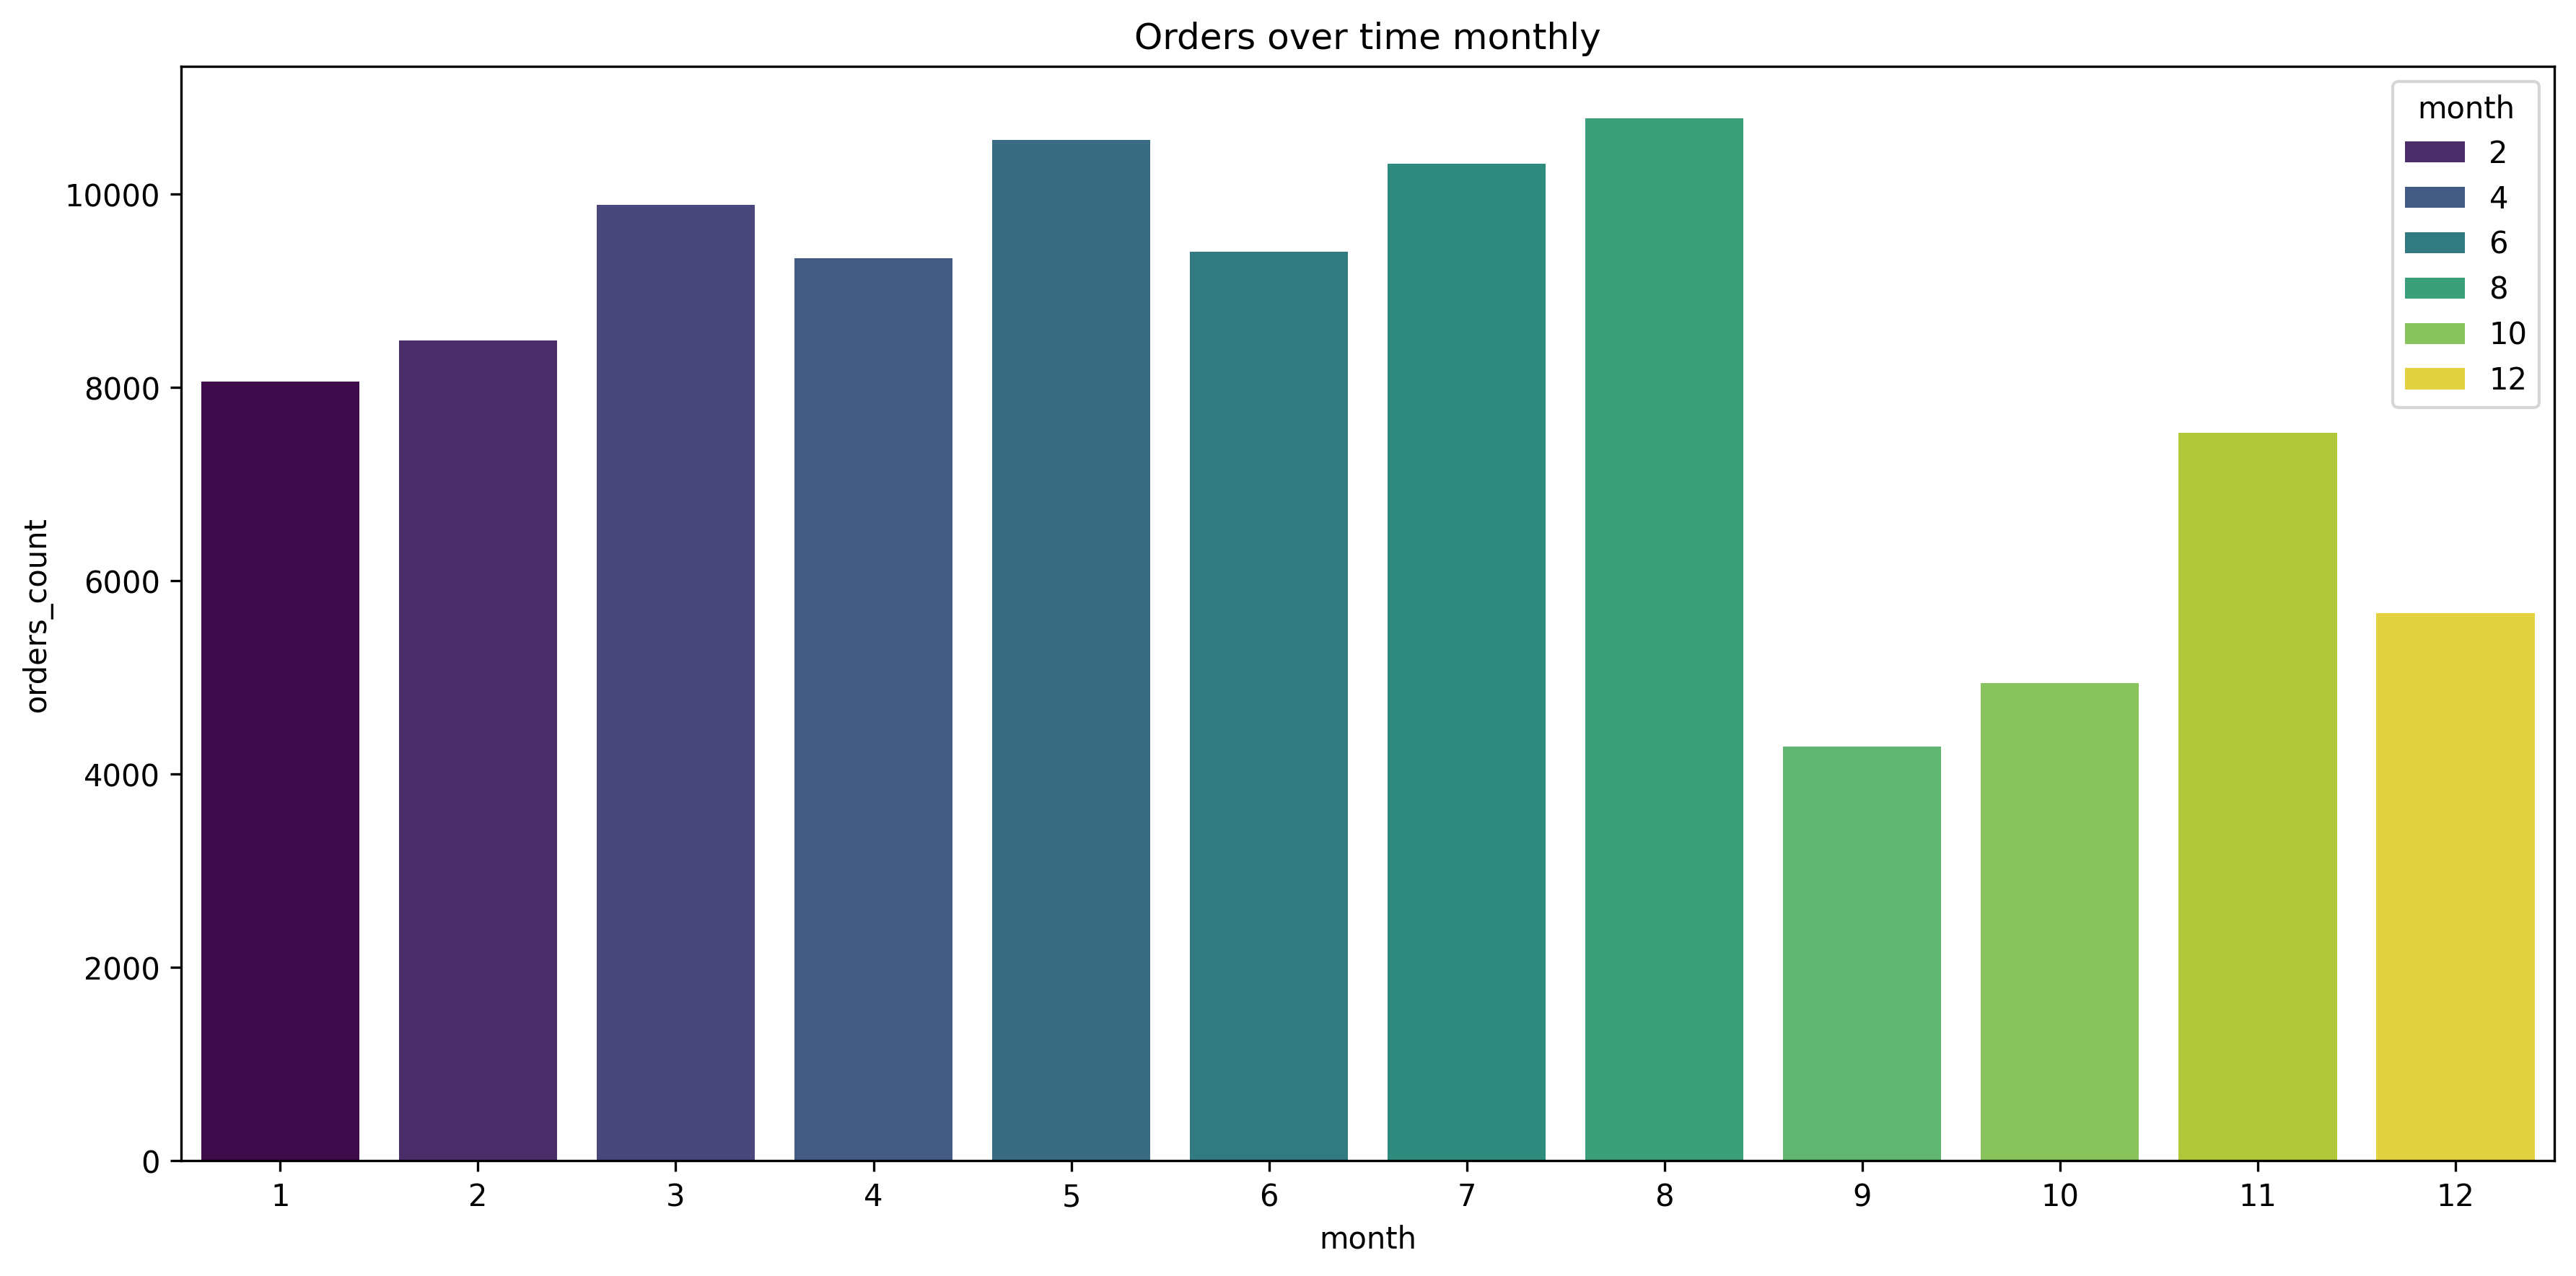

In [26]:
orders["month"] = orders["order_purchase_timestamp"].dt.month
orders_per_month = orders.groupby("month").size().reset_index(name = "orders_count")
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300) 
sns.barplot(data = orders_per_month, x = "month", y = "orders_count", hue = "month", palette = "viridis")
plt.title("Orders over time monthly")
plt.tight_layout()
plt.savefig("../output/charts/orders_per_month.png", dpi = 300)

> - As we can see in the chart, the months with the biggest number of orders are 8,7,5,3
> - The months with the least number of orders are 9,10,11,12

##### Orders per year : 

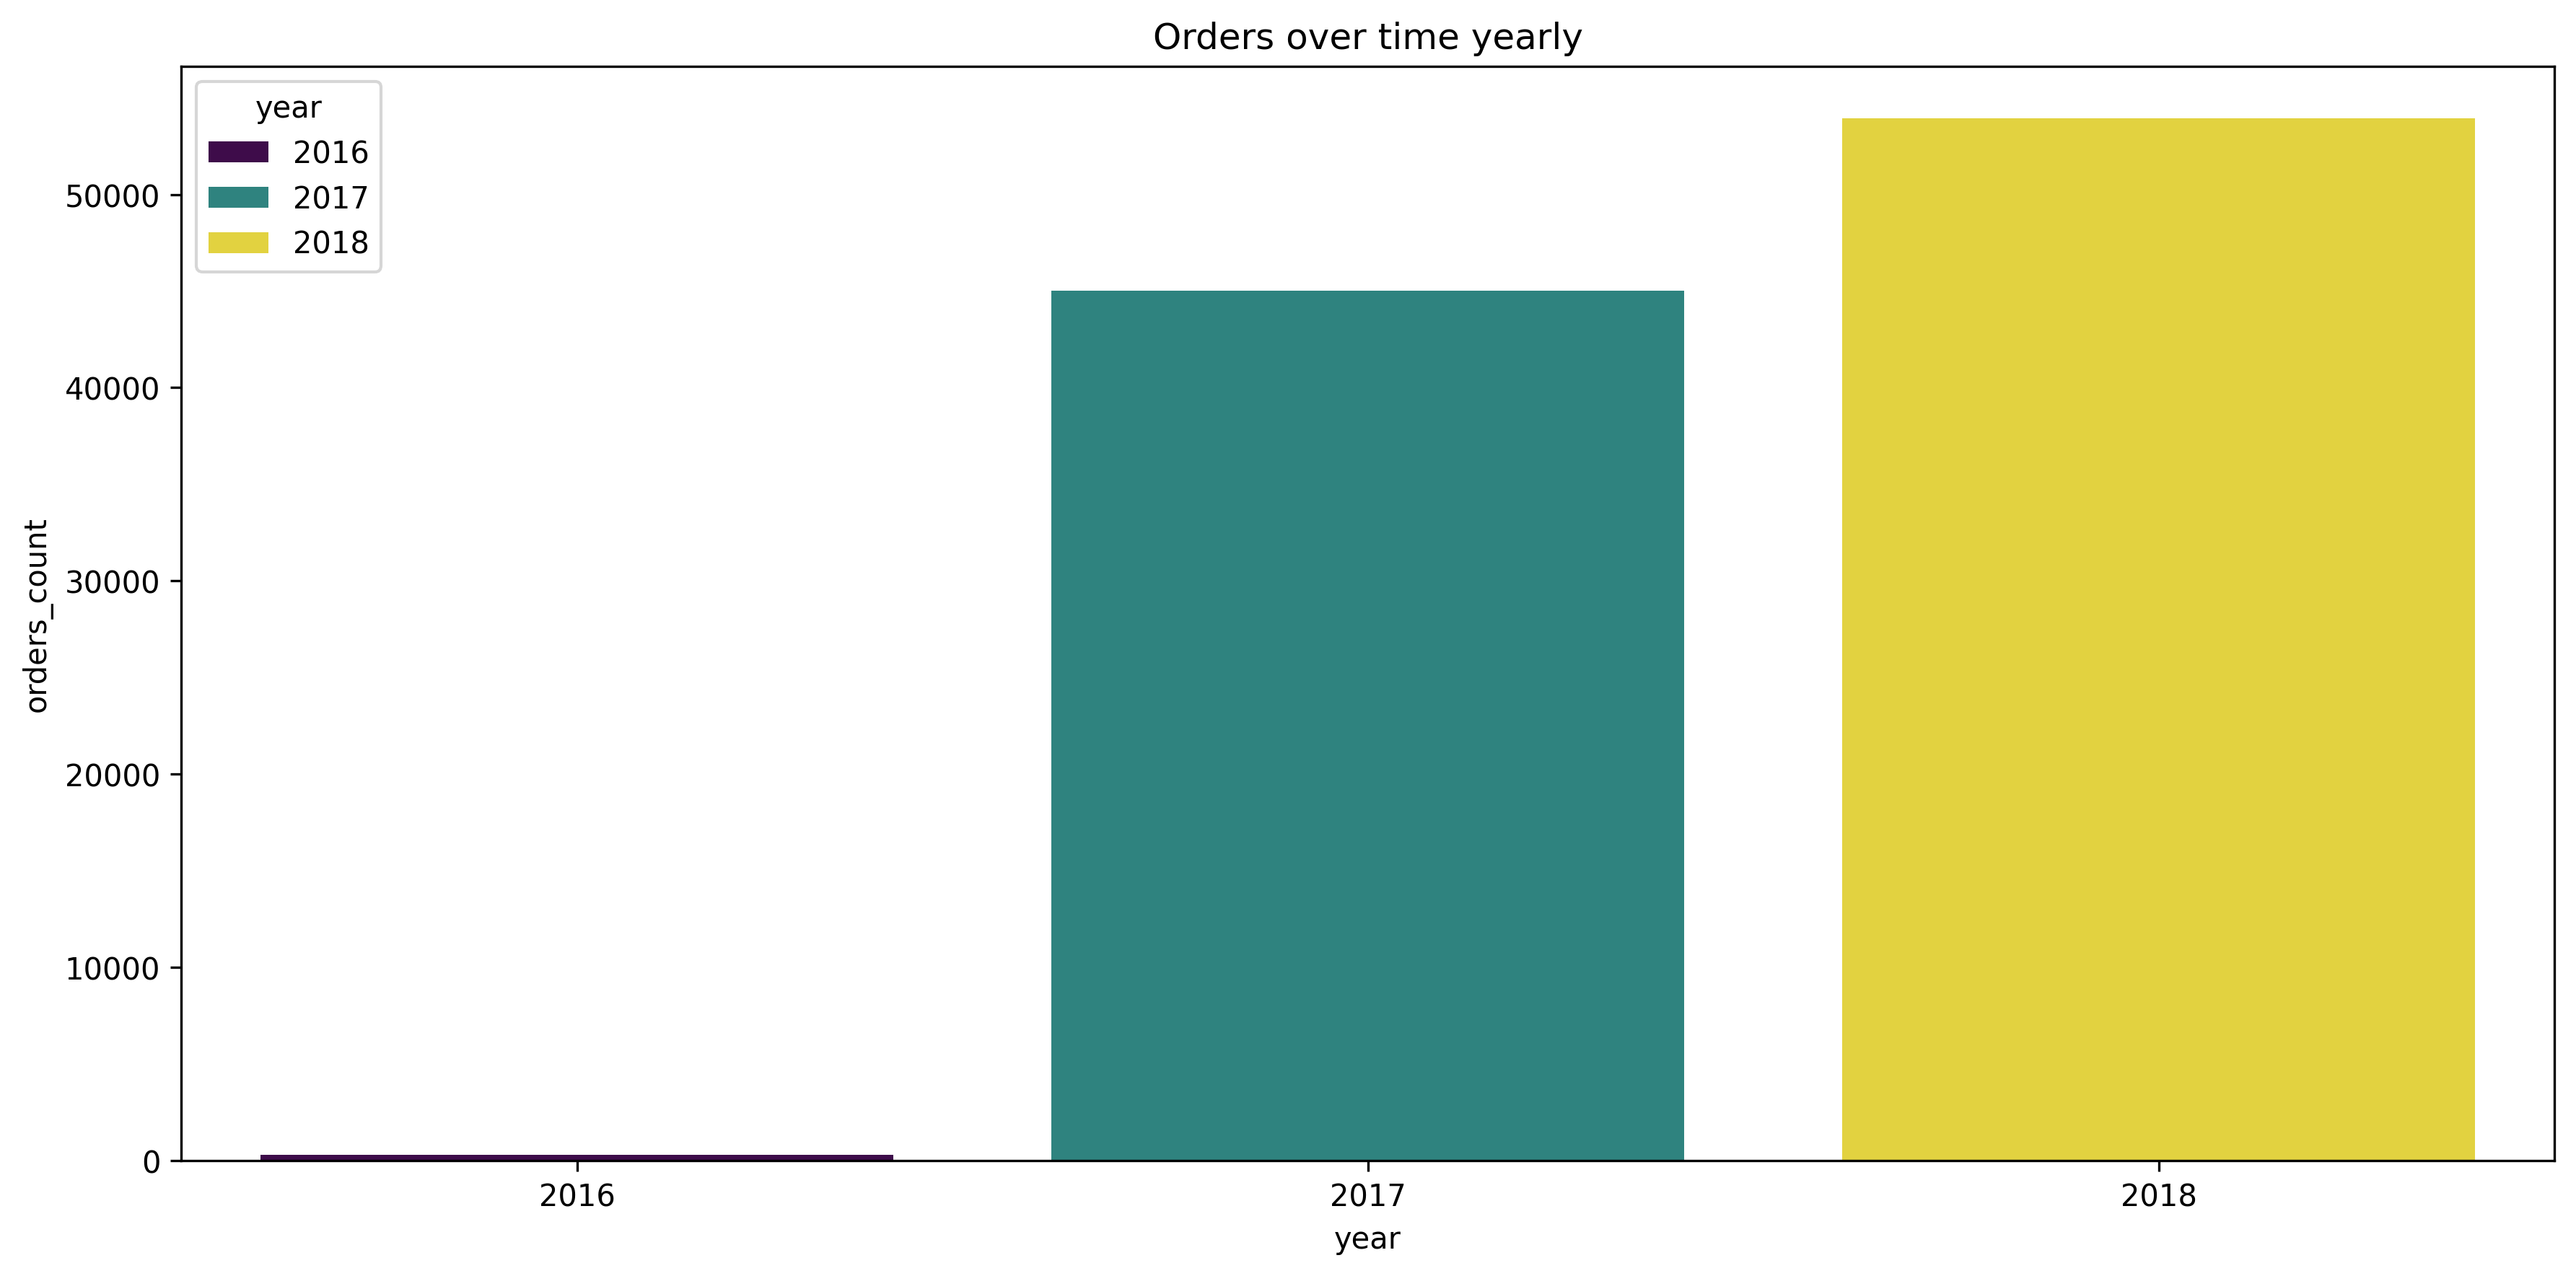

In [27]:
orders["year"] = orders["order_purchase_timestamp"].dt.year
orders_per_year = orders.groupby("year").size().reset_index(name = "orders_count")

fig, ax = plt.subplots(figsize = (12, 6), dpi = 300) 
sns.barplot(data = orders_per_year, x = "year",y = "orders_count", hue = "year", palette = "viridis")
plt.title("Orders over time yearly")
plt.tight_layout()
plt.savefig("../output/charts/orders_per_year.png", dpi = 300)

> The number of orders increased dramatically from 2016 to 2017.
In 2016, the platform had very few orders, while in 2017 the number of orders grew approximately 100×, showing a rapid adoption of the service.

#### Visualizing order status distribution

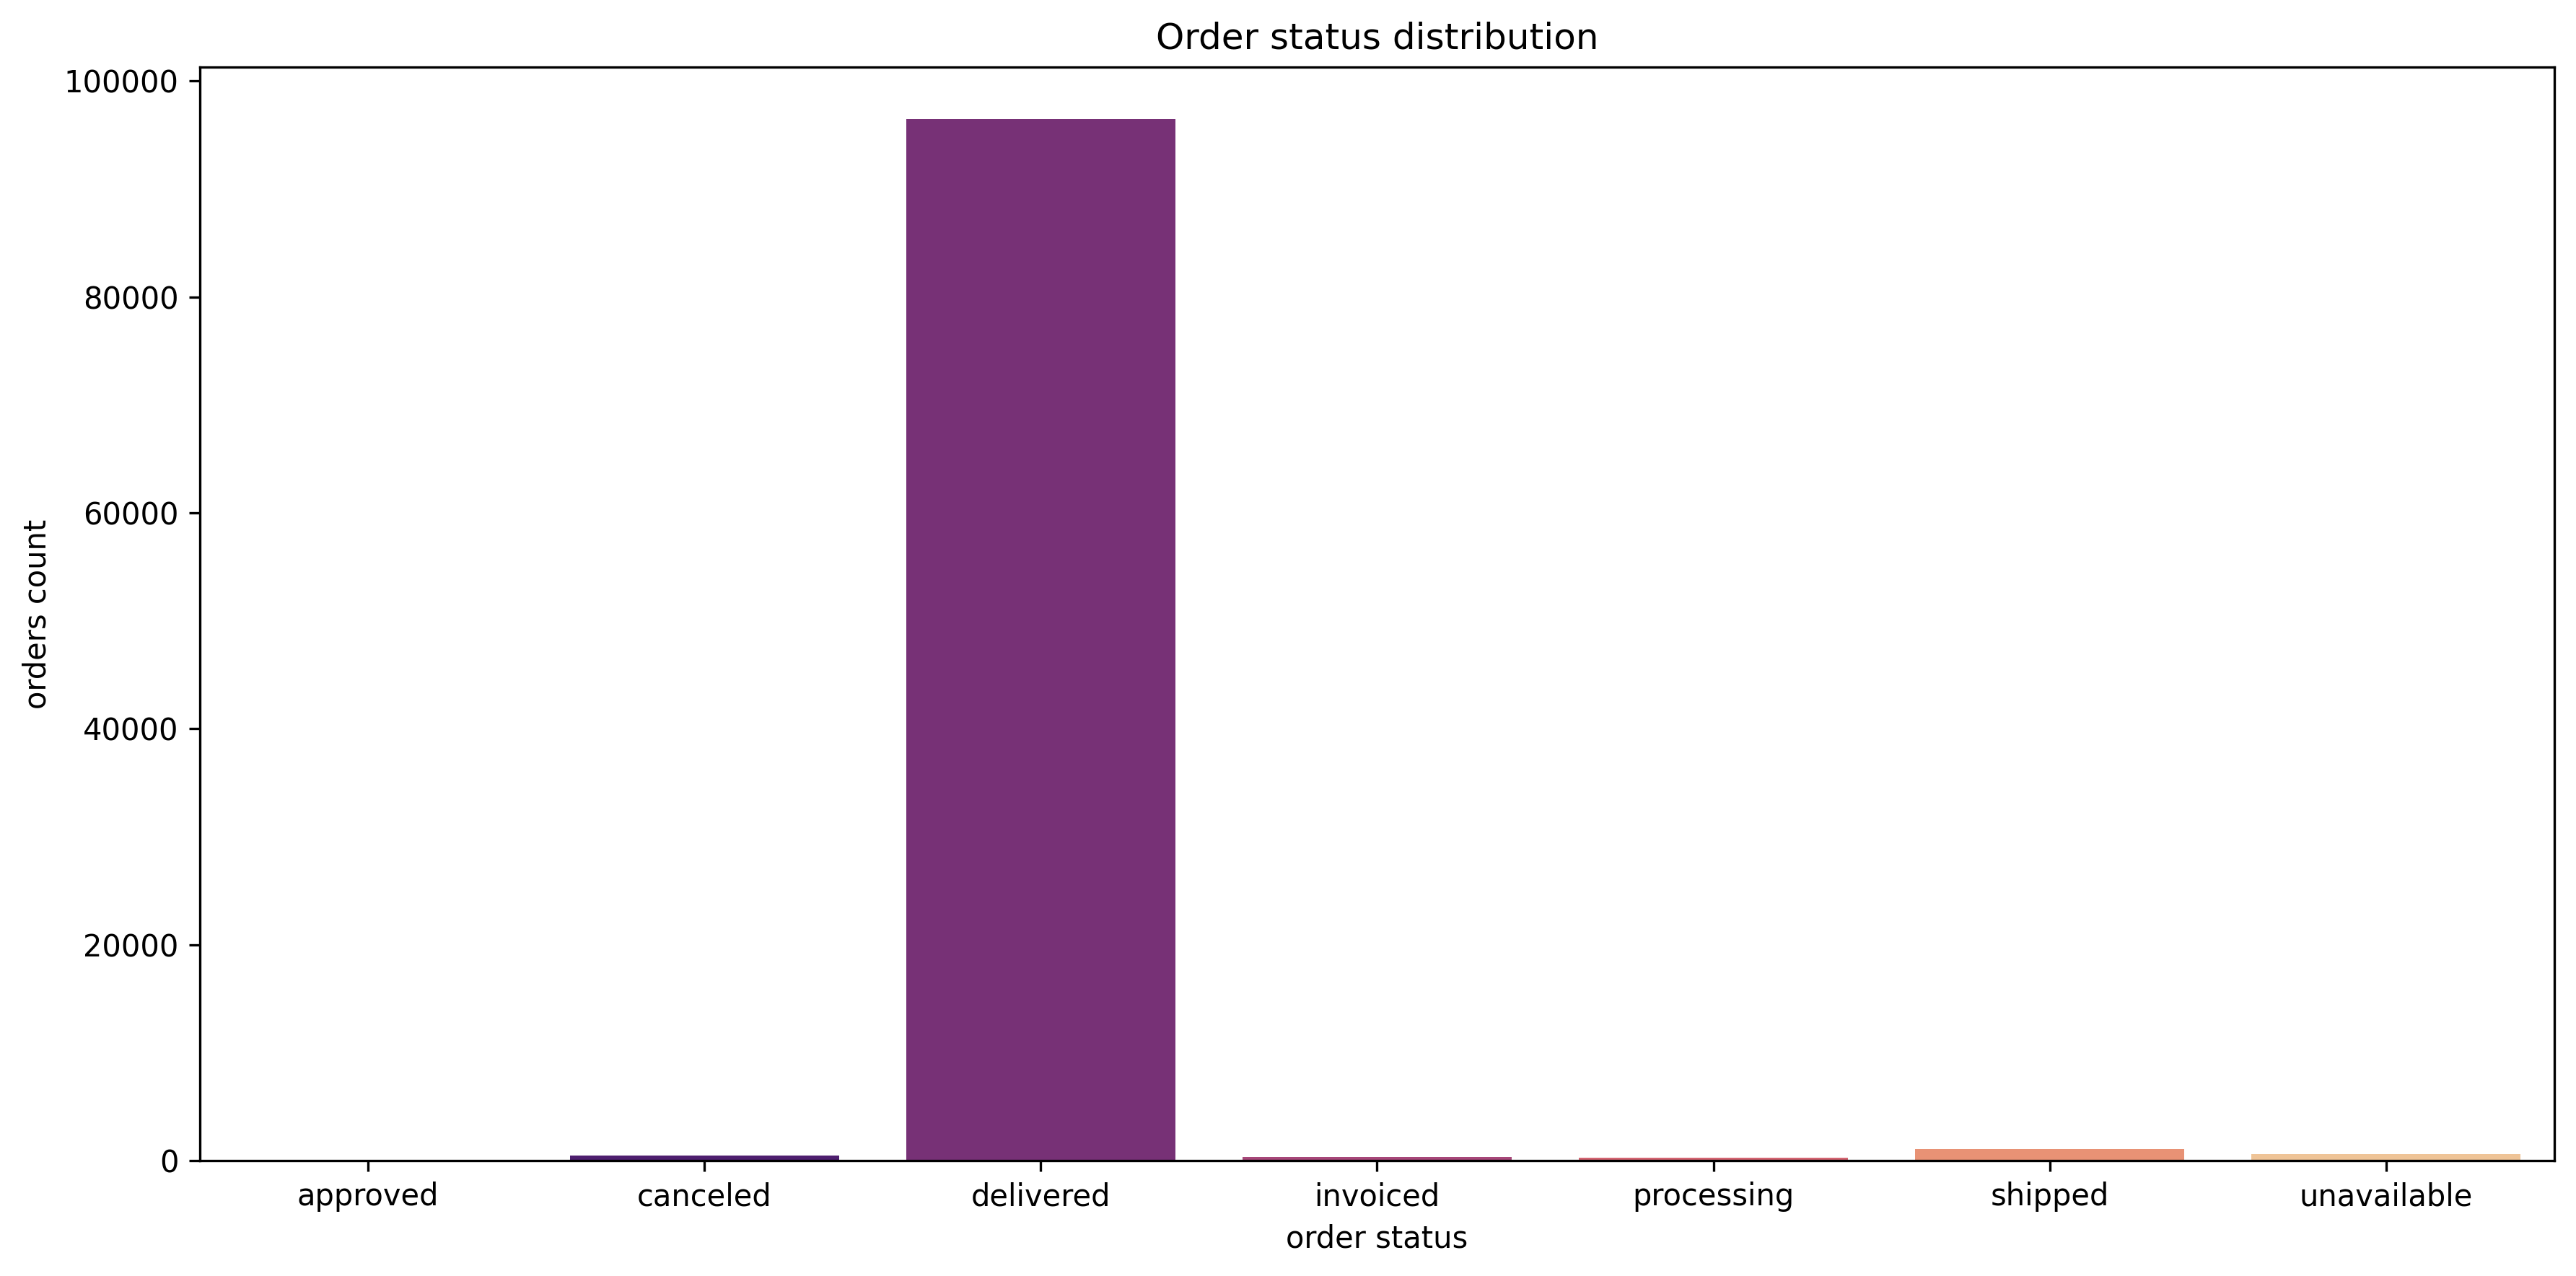

In [28]:
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300) 
order_status = orders.groupby("order_status").size().reset_index(name = "value_count")
sns.barplot(data = order_status, x = "order_status", y = "value_count", hue = "order_status", palette = "magma") 
plt.title("Order status distribution")
ax.set_ylabel("orders count")
plt.tight_layout()
ax.set_xlabel("order status")
plt.savefig("../output/charts/status_distribution.png", dpi = 300)

> As we can see in the chart, most orders are delivered, while a smaller portion of orders vary in status

#### Visualizing revenue over time 

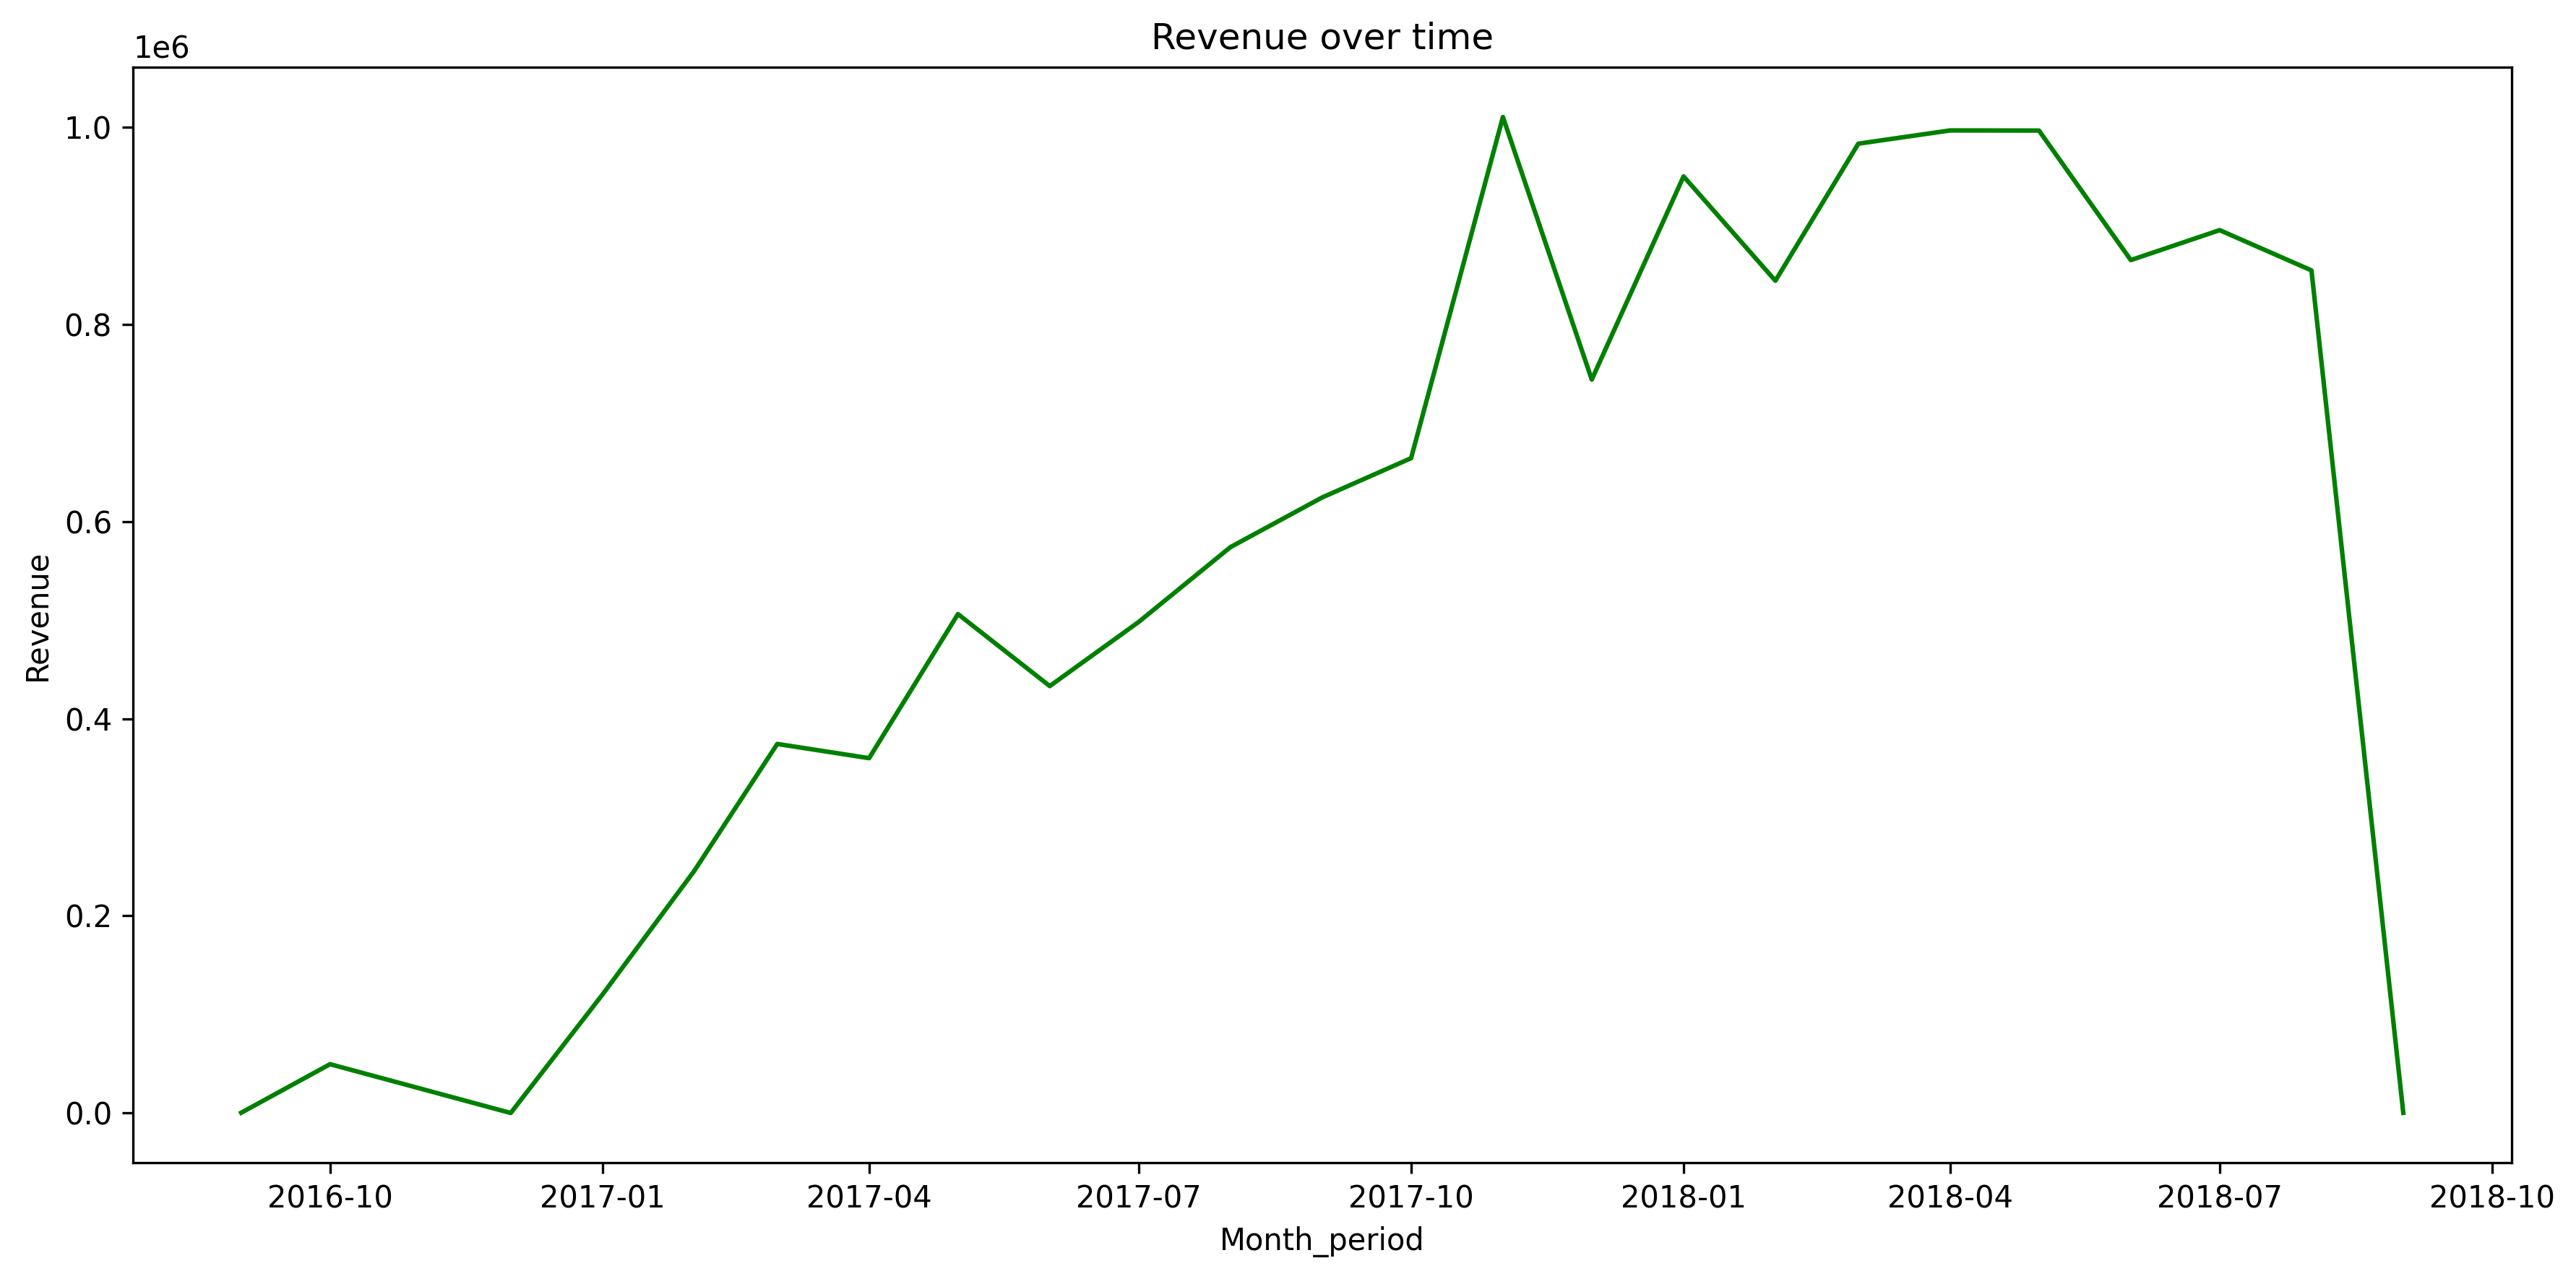

In [29]:
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
orders_items = orders.merge(
    items,
    on = "order_id",
    how = "left" 
)
orders_items["year_month"] = orders_items["order_purchase_timestamp"].dt.to_period("M")
revenue_per_month_year = orders_items.groupby("year_month")["price"].sum().reset_index(name = "value_count")
#converting period to datetime for visualizing :
revenue_per_month_year['year_month'] = revenue_per_month_year['year_month'].dt.to_timestamp()

sns.lineplot(data = revenue_per_month_year, x = 'year_month', y = 'value_count', color = "green")
plt.title("Revenue over time")
ax.set_xlabel("Month_period")
ax.set_ylabel("Revenue")
plt.tight_layout()
plt.savefig("../output/charts/revenue_over_time.png", dpi = 300)

> - Orders had droped dramatically between 2018-07 and 2018-10
> - The period with the highest revenue is between 2017-10 and 2018-01

#### Visualizing top products by revenue

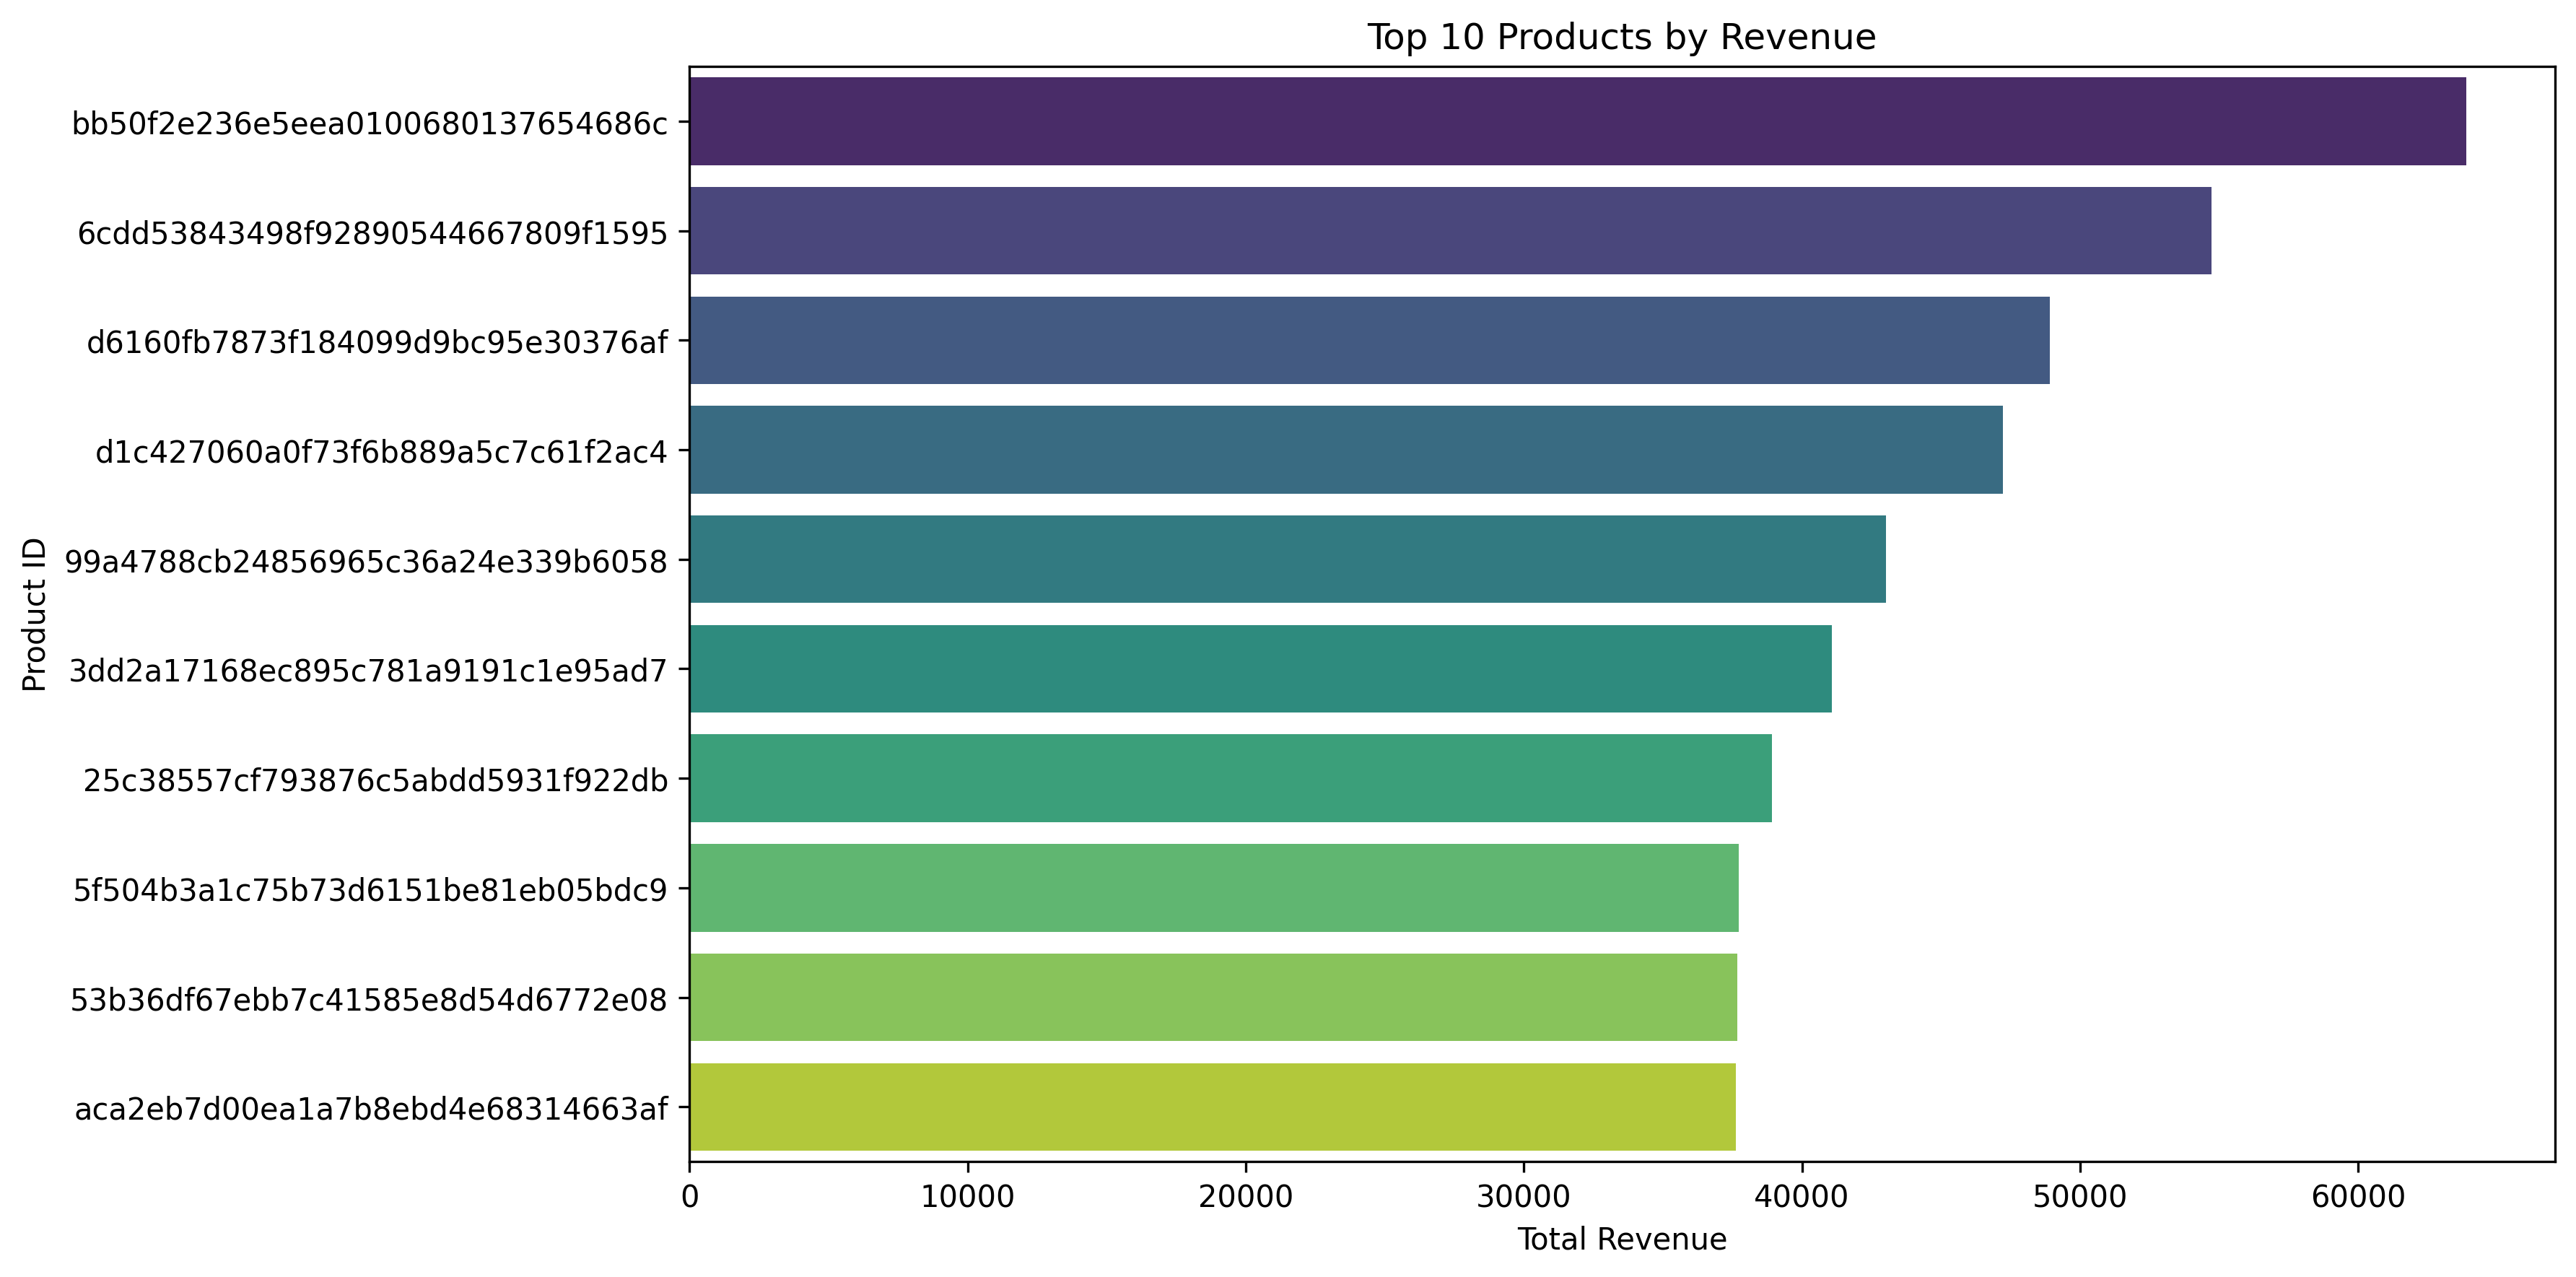

In [30]:
top_products = orders_items.groupby("product_id")["price"].sum().reset_index(name = "product_revenue").sort_values(by = "product_revenue",ascending = False)
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.barplot(data = top_products.head(10) , x = "product_revenue",y = "product_id",hue ="product_id", palette = "viridis")
ax.set_title("Top 10 Products by Revenue")
ax.set_xlabel("Total Revenue")
ax.set_ylabel("Product ID")
plt.tight_layout()
plt.savefig("../output/charts/top_products_by_revenue.png", dpi = 300)

> As we can see in the chart, the product with the biggest revenue is with the ID : *bb50f2e236e5eea0100680137654686c*

#### Visualizing top sellers by revenue 

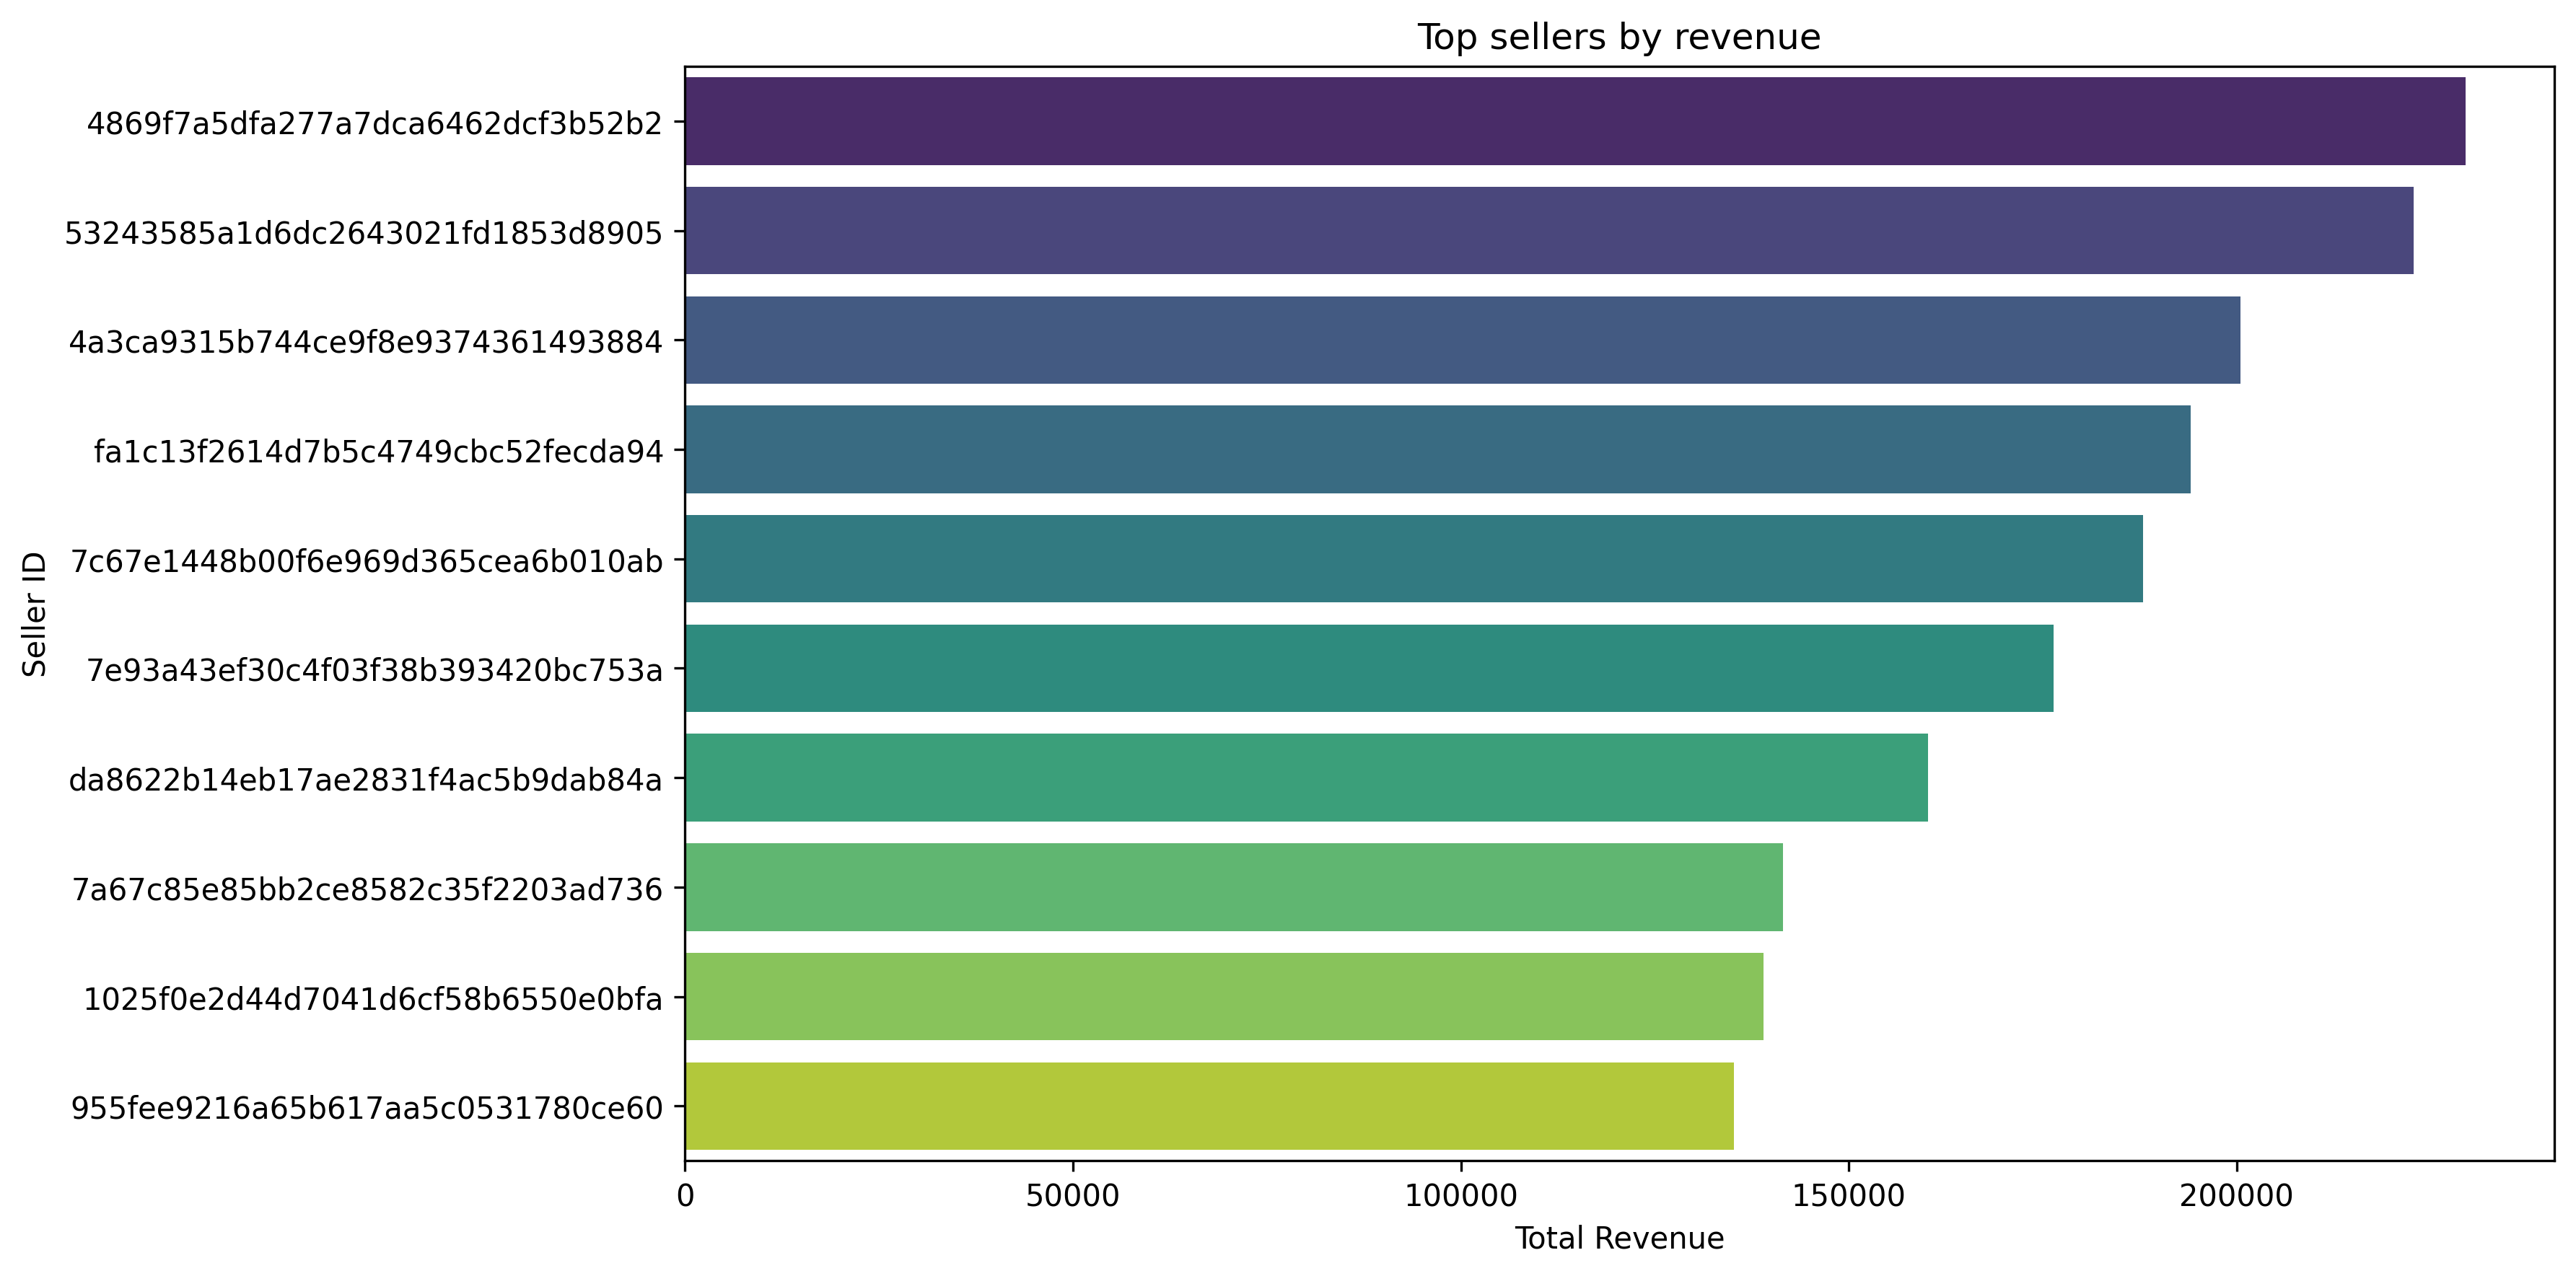

In [31]:
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
top_sellers = orders_items.groupby("seller_id")["price"].sum().reset_index(name = "seller_revenue").sort_values(by = "seller_revenue",ascending = False)
sns.barplot(data = top_sellers.head(10) , x = "seller_revenue",y = "seller_id",hue ="seller_id", palette = "viridis")
ax.set_title("Top sellers by revenue")
ax.set_xlabel("Total Revenue")
ax.set_ylabel("Seller ID")
plt.tight_layout()
plt.savefig("../output/charts/top_sellers_by_revenue.png", dpi = 300)

> As we can see in the chart, the seller with the highest revenue is with the ID  : *4869f7a5dfa277a7dca6462dcf3b52b2*

#### Visualizing delivery delay distribution

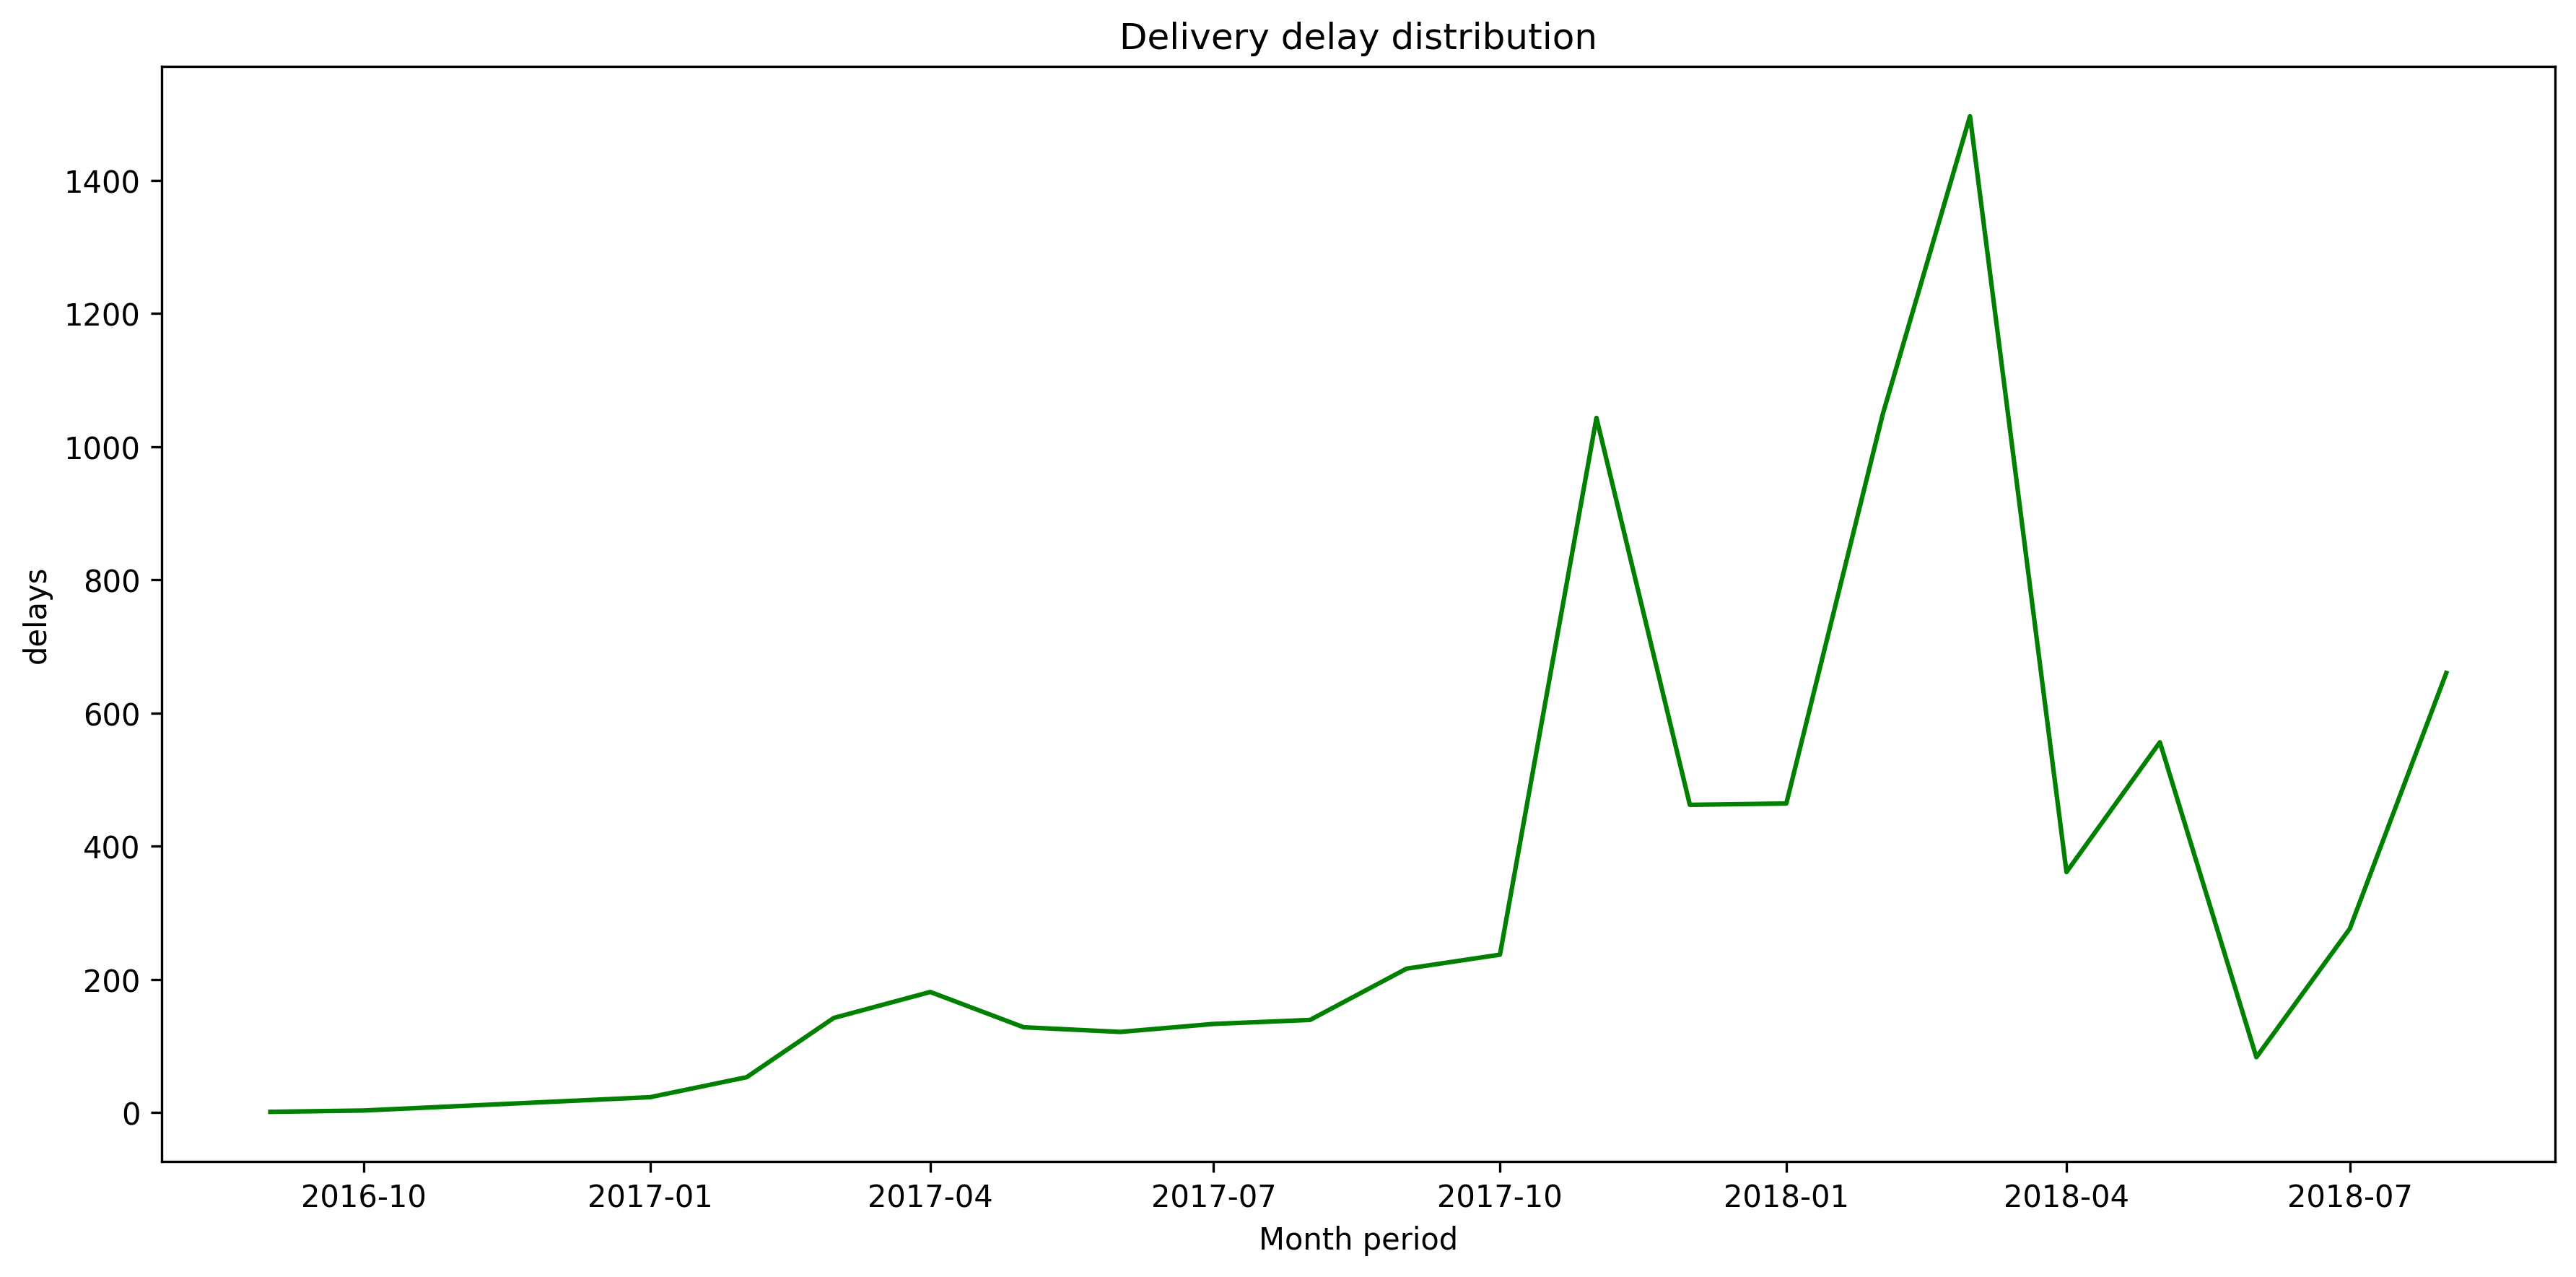

In [32]:
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
orders["year_month"]= orders["order_purchase_timestamp"].dt.to_period("M")
delivery_delay_distribution = orders[orders["order_delivered_customer_date"] > orders["order_estimated_delivery_date"]].groupby("year_month").size().reset_index(name = "delays")
delivery_delay_distribution["year_month"] = (
    delivery_delay_distribution["year_month"].dt.to_timestamp()
)
sns.lineplot(data = delivery_delay_distribution, x = "year_month", y = "delays", color = "green") 
plt.title("Delivery delay distribution")
ax.set_xlabel("Month period")
plt.tight_layout()
plt.savefig("../output/charts/delivery_delay_distribution.png", dpi = 300)

> - The period with the most delays is between 2018-01 and 2018-04
> - After 2018-04, both orders and the total number of delays decreased.

#### Visualizing on-time vs late deliveries

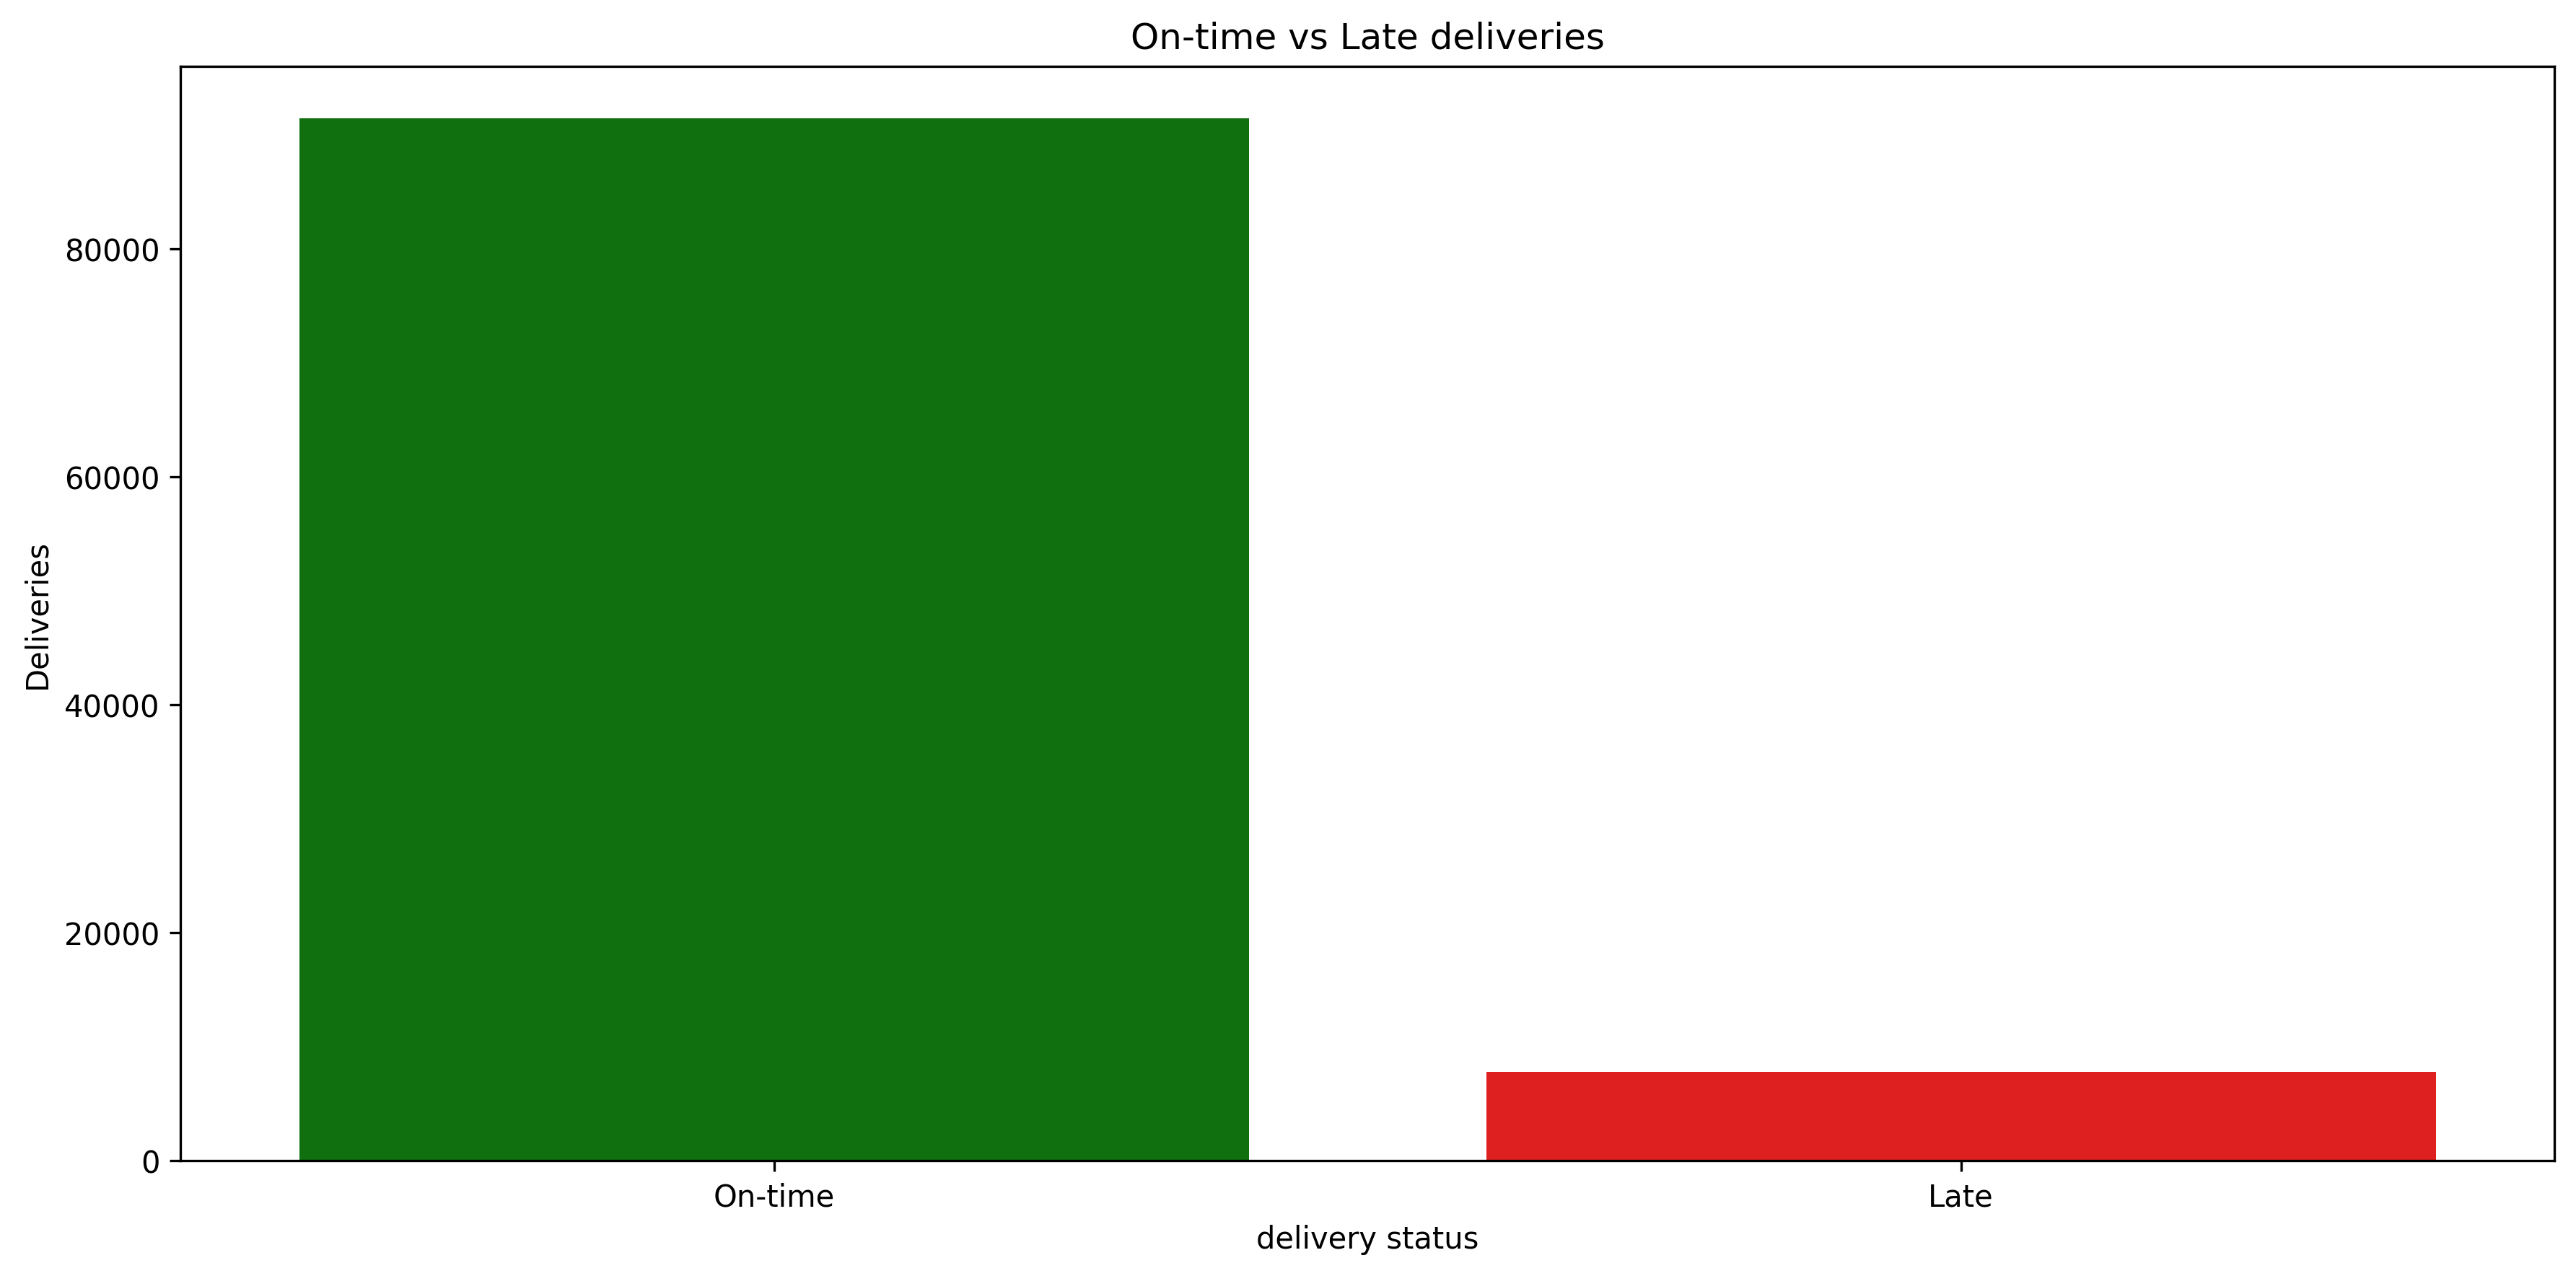

In [33]:
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
orders["delivery_status"] = orders["order_delivered_customer_date"] > orders["order_estimated_delivery_date"] 
orders["delivery_status"] = orders["delivery_status"].map({
    True : "Late",
    False : "On-time"
})
sns.countplot(data = orders, x = "delivery_status",hue = "delivery_status" ,palette = {"Late":"red","On-time":"green"})
plt.title("On-time vs Late deliveries")
ax.set_xlabel("delivery status")
ax.set_ylabel("Deliveries")
plt.tight_layout()
plt.savefig("../output/charts/on-time_vs_late_deliveries.png", dpi = 300)

> We can see that most orders are delivered **on time**(green bar), while a small portion was delivered **late**(red bar)

#### Visualizing average delivery delay over time 

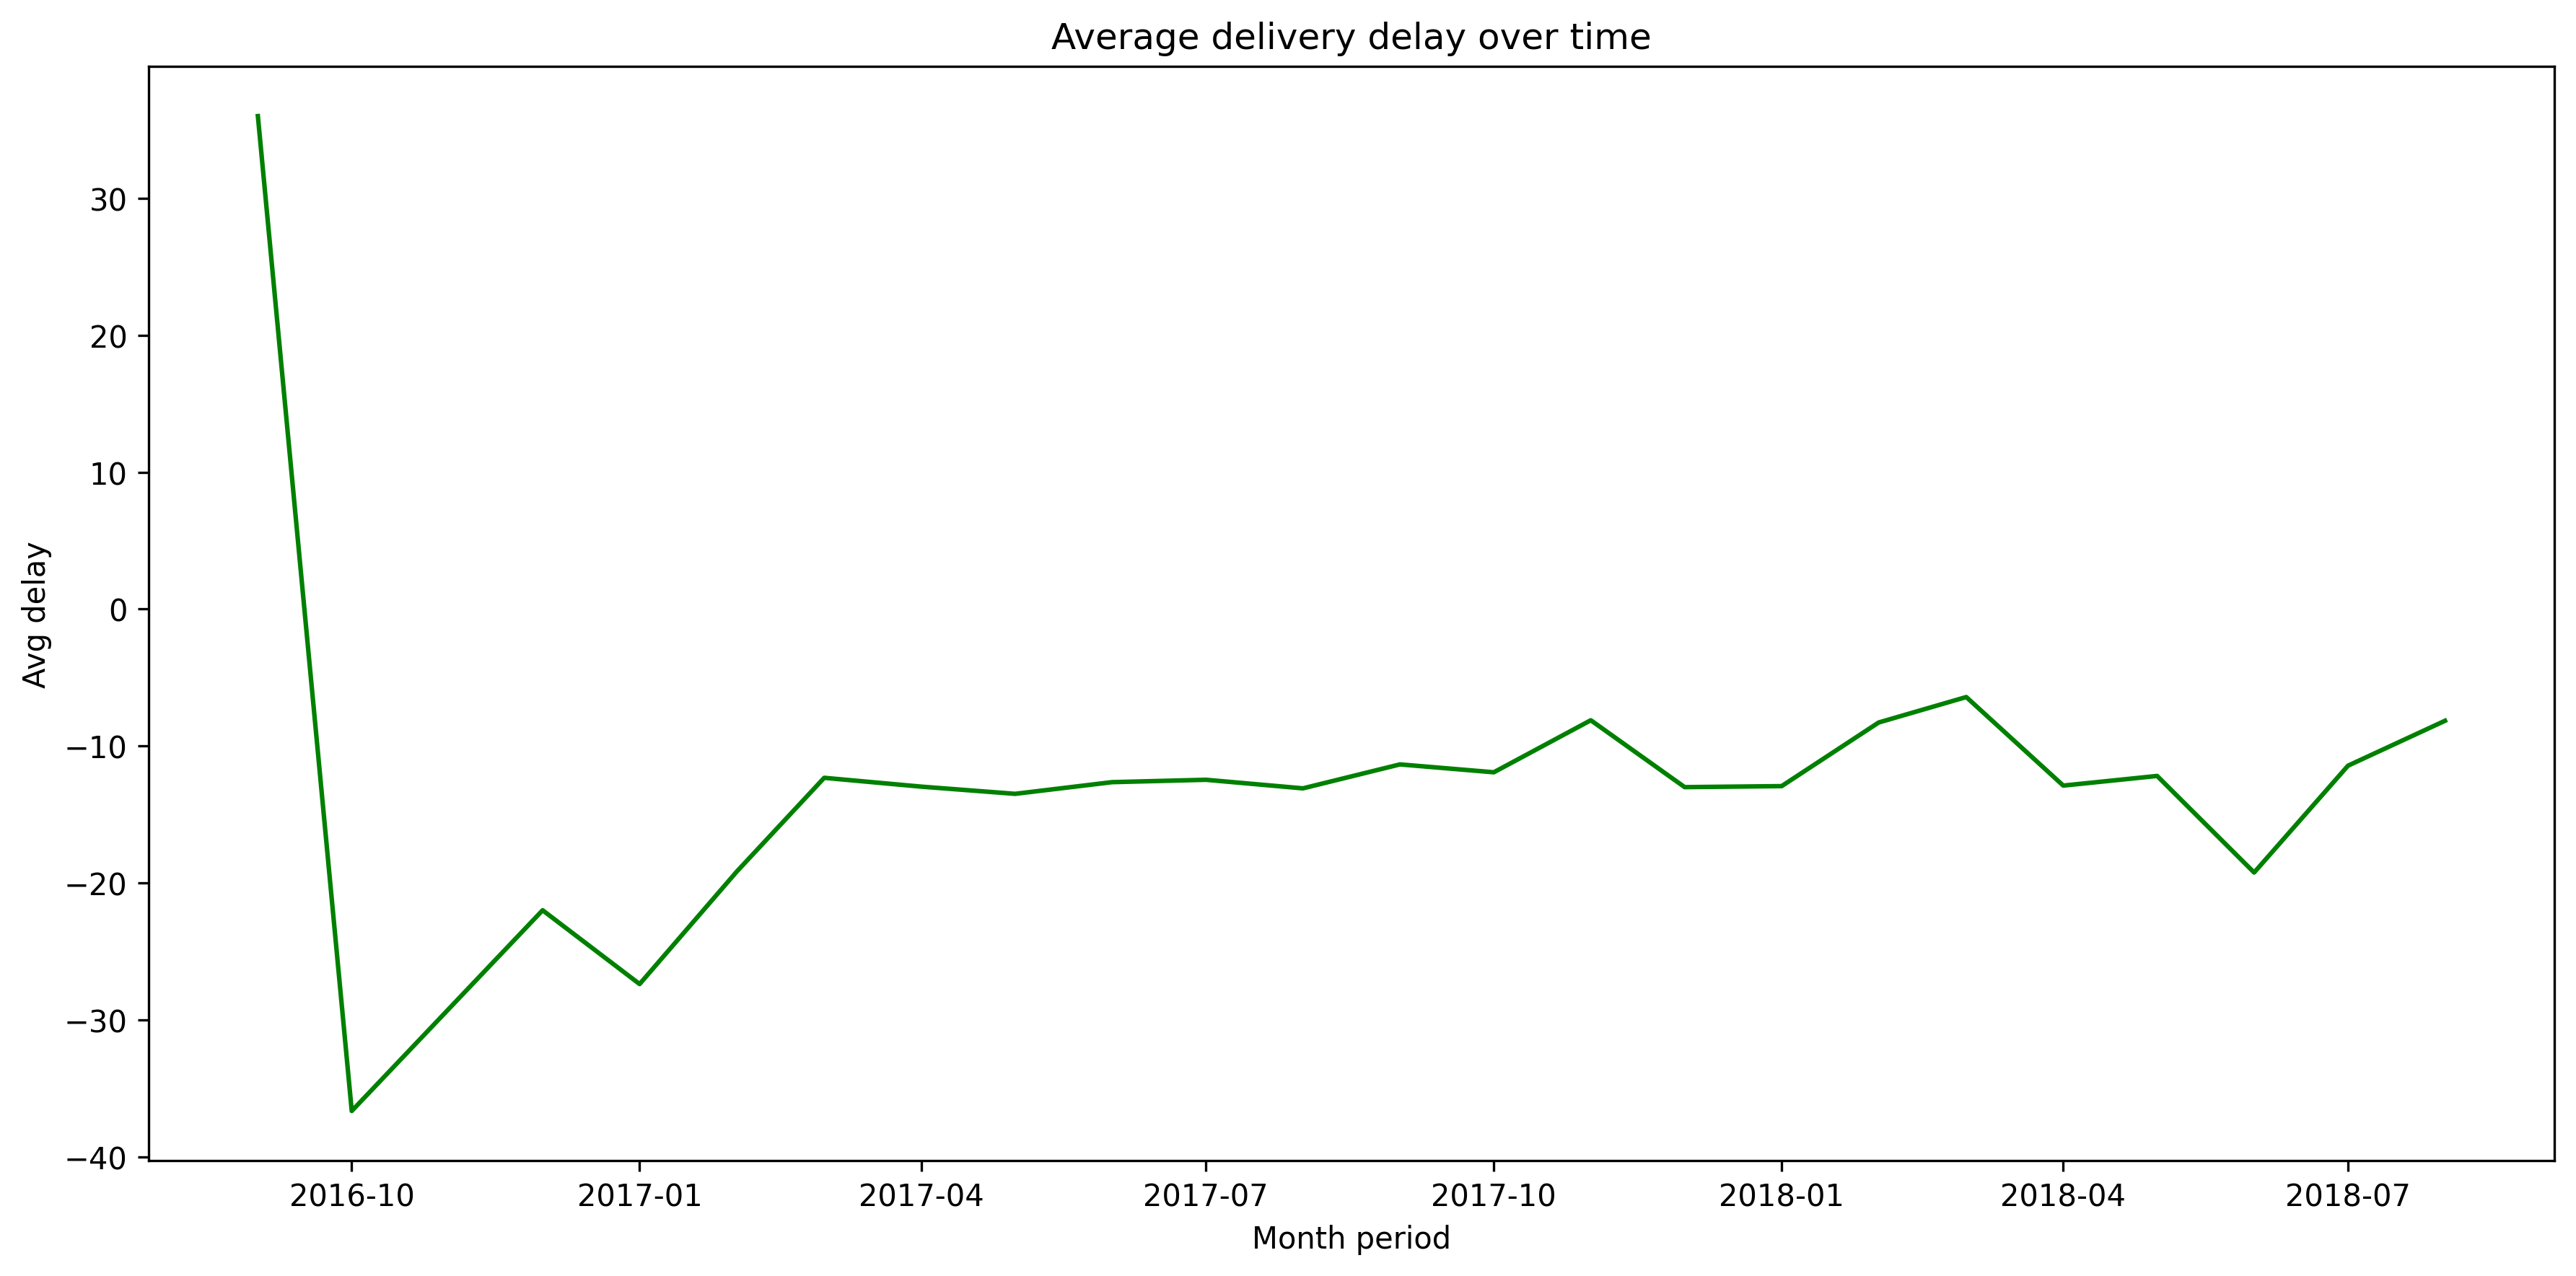

In [34]:
orders["delivery_delay"] = (orders["order_delivered_customer_date"] - orders["order_estimated_delivery_date"]).dt.days
orders["month_period"] = orders["order_purchase_timestamp"].dt.to_period("M")
orders["month_period"] = orders["month_period"].dt.to_timestamp()
avg_delay = orders.groupby("month_period")["delivery_delay"].mean().reset_index()
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.lineplot(data = avg_delay, x = "month_period", y = "delivery_delay",color = "green")
ax.set_xlabel("Month period")
ax.set_ylabel("Avg delay")
plt.title("Average delivery delay over time")
plt.tight_layout()
plt.savefig("../output/charts/average_delivery_delay.png", dpi = 300)

> - Most deliveries are not delayed and arrive earlier than expected  
> - Negative values on the Y axis (-) means the order arrived earlier than expected

#### Visualizing orders per customer (repeat and one-time)

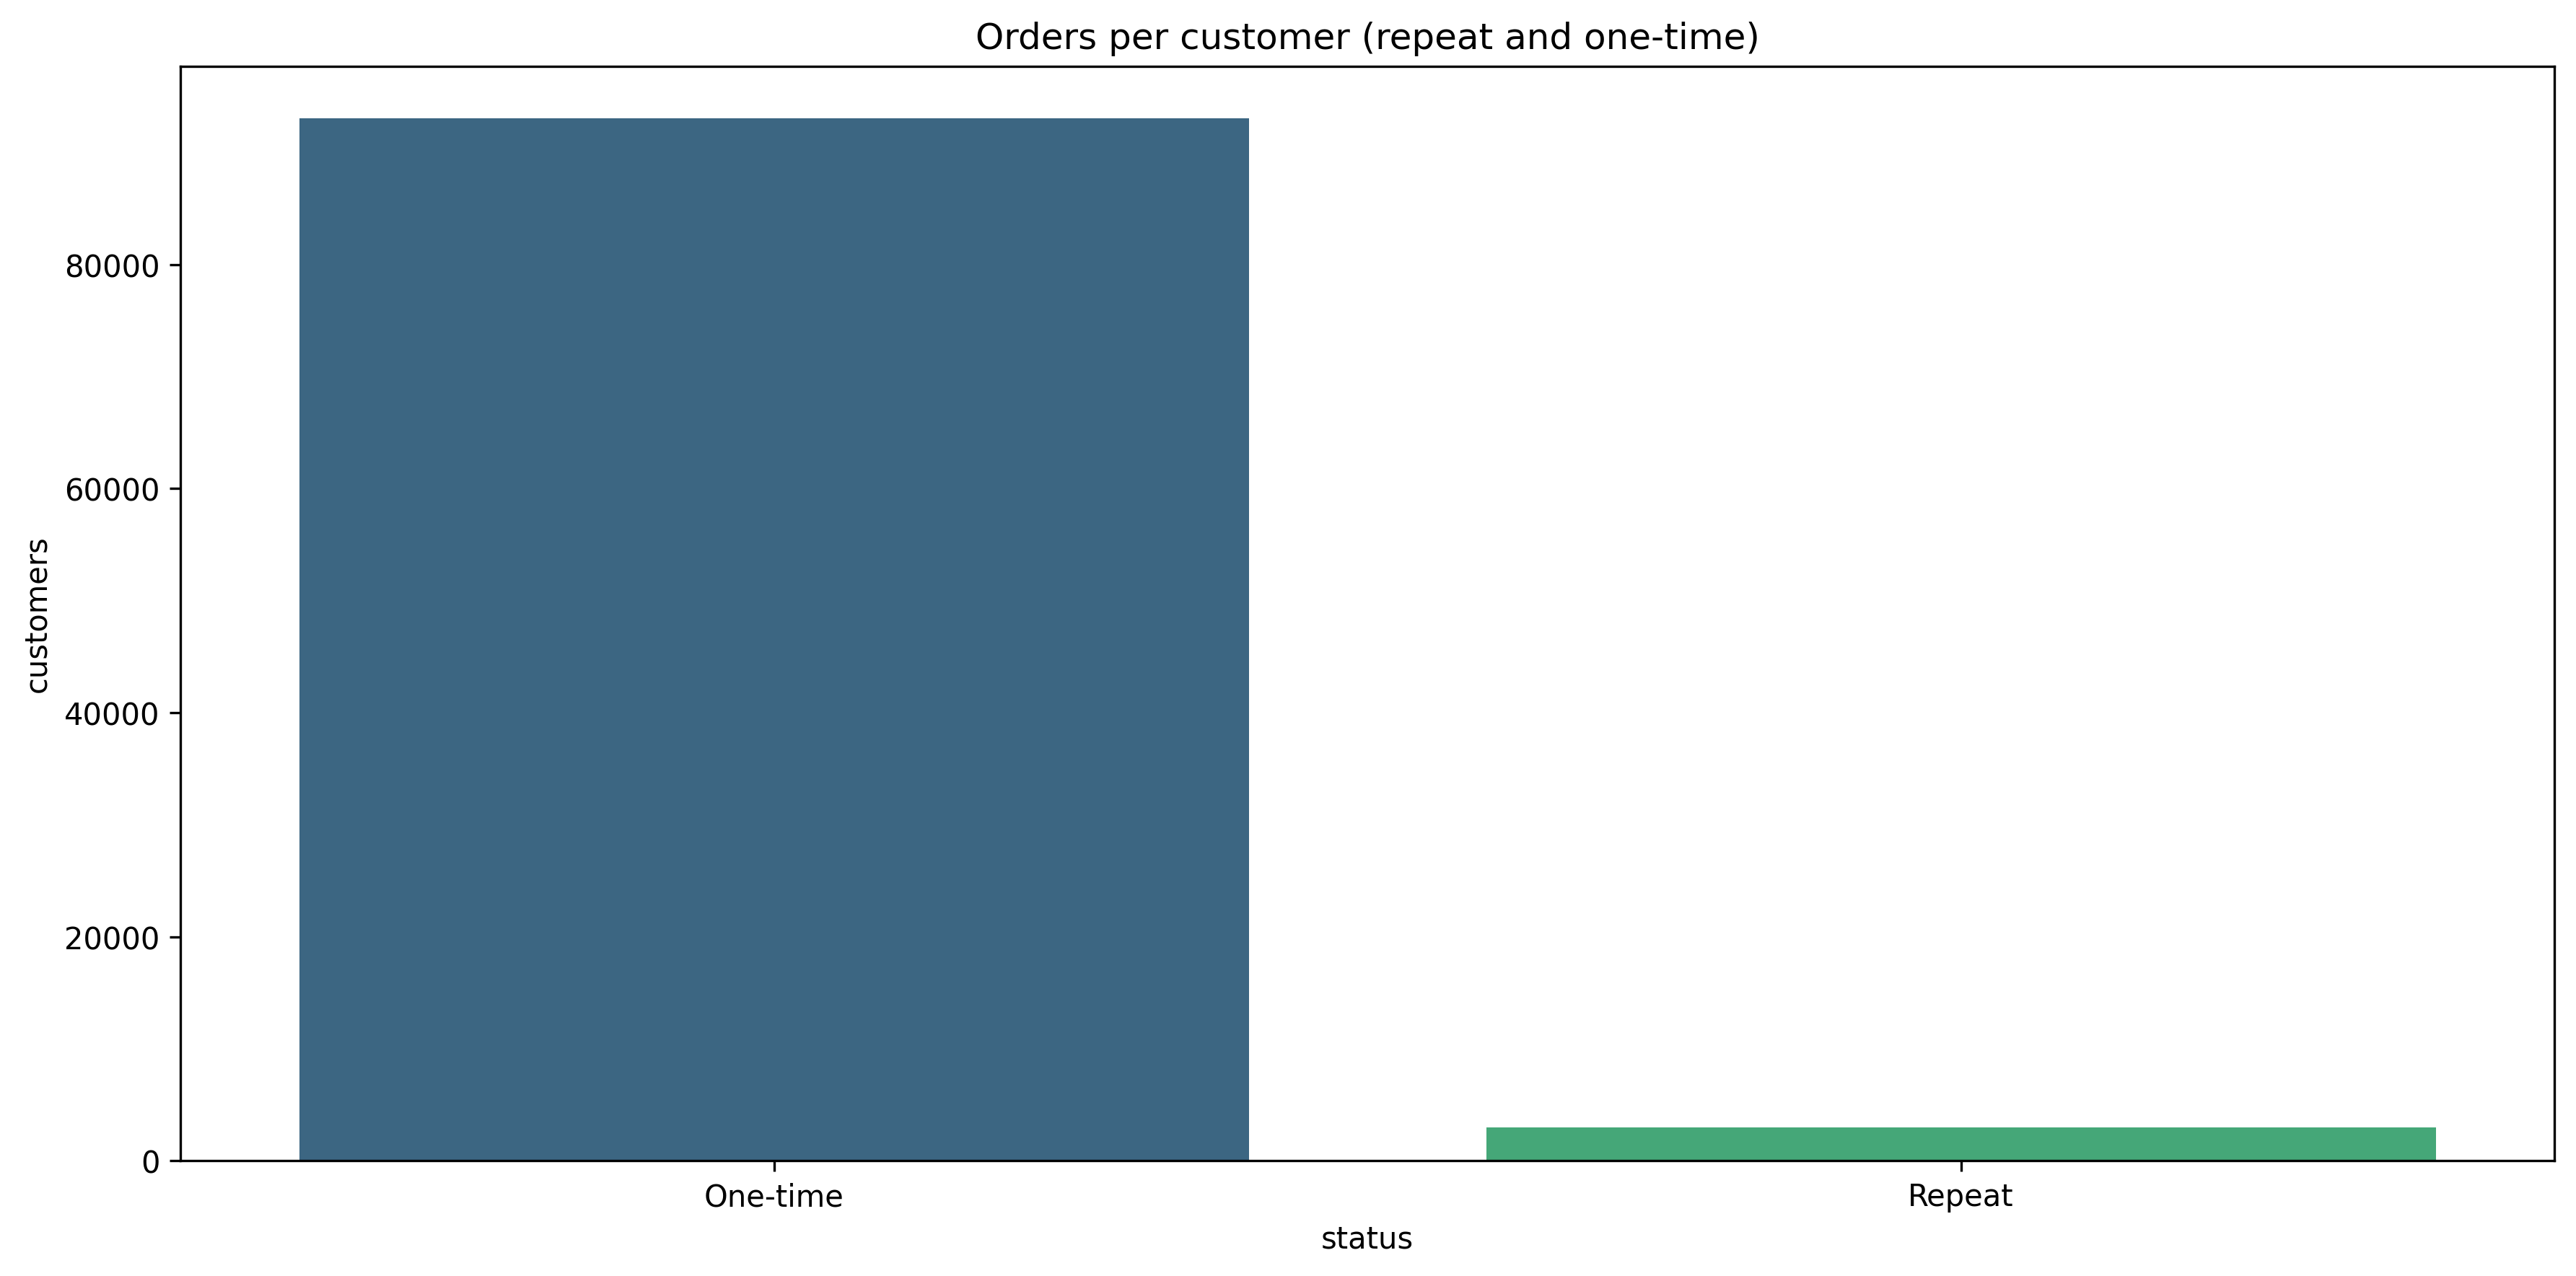

In [35]:
customer_orders = orders_customers.groupby("customer_unique_id").size().reset_index(name = "orders")
customer_orders["status"] = customer_orders["orders"] > 1 
customer_status = customer_orders.value_counts("status").reset_index(name = "customers")
customer_status["status"] = customer_status["status"].map({True : "Repeat", False : "One-time"})
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.barplot(data = customer_status, x = "status", y = "customers",hue  = "status",palette = "viridis")
plt.title("Orders per customer (repeat and one-time)")
plt.tight_layout()
plt.savefig("../output/charts/customer_status.png", dpi = 300)

> As we can see in the chart the majority of the customers only buy once from the store, indicating a **low rate** of repeat buying.

#### Visualizing top customers by total spend

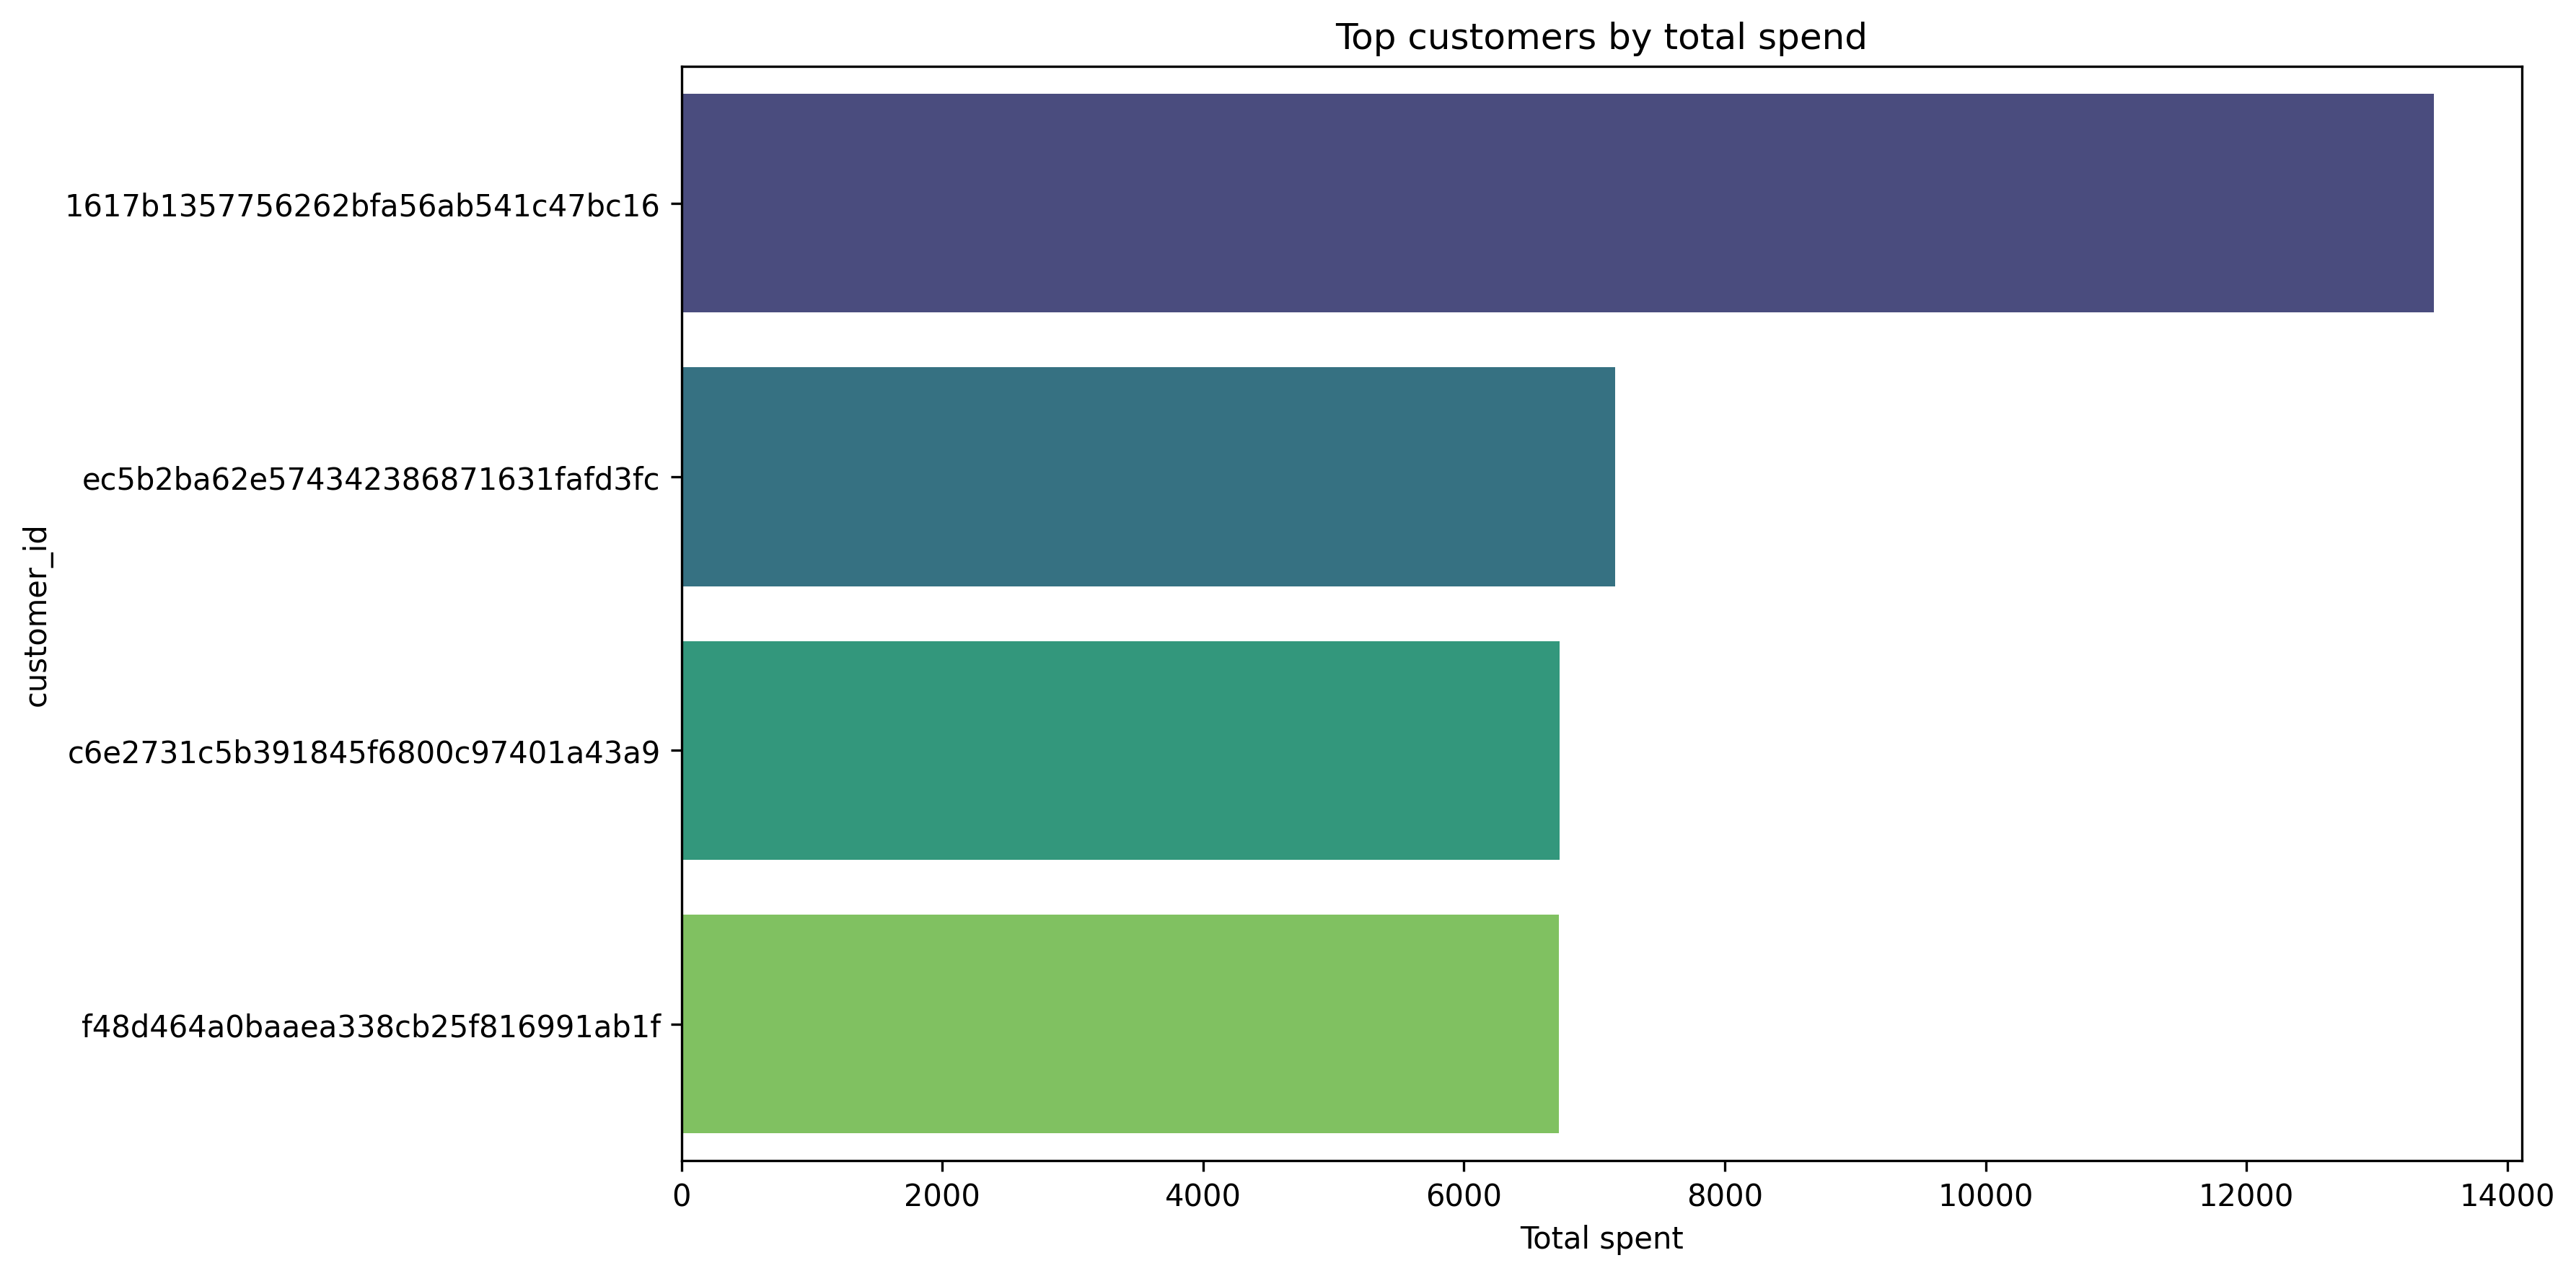

In [48]:
top_customers = orders_items.groupby("customer_id")["price"].sum().reset_index(name="total_spent").sort_values(by = "total_spent",ascending = False)
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.barplot(data = top_customers.head(4), x = "total_spent", y = "customer_id", hue = "customer_id", palette = "viridis")
ax.set_xlabel("Total spent")
plt.title("Top customers by total spend")
plt.tight_layout()
plt.savefig("../output/charts/top_customers.png", dpi = 300)

> The **top customer** with over 16 orders is with the ID : *8d50f5eadf50201ccdcedfb9e2ac8455*

#### Visualizing customer distribution by location (state/city)

##### By city 

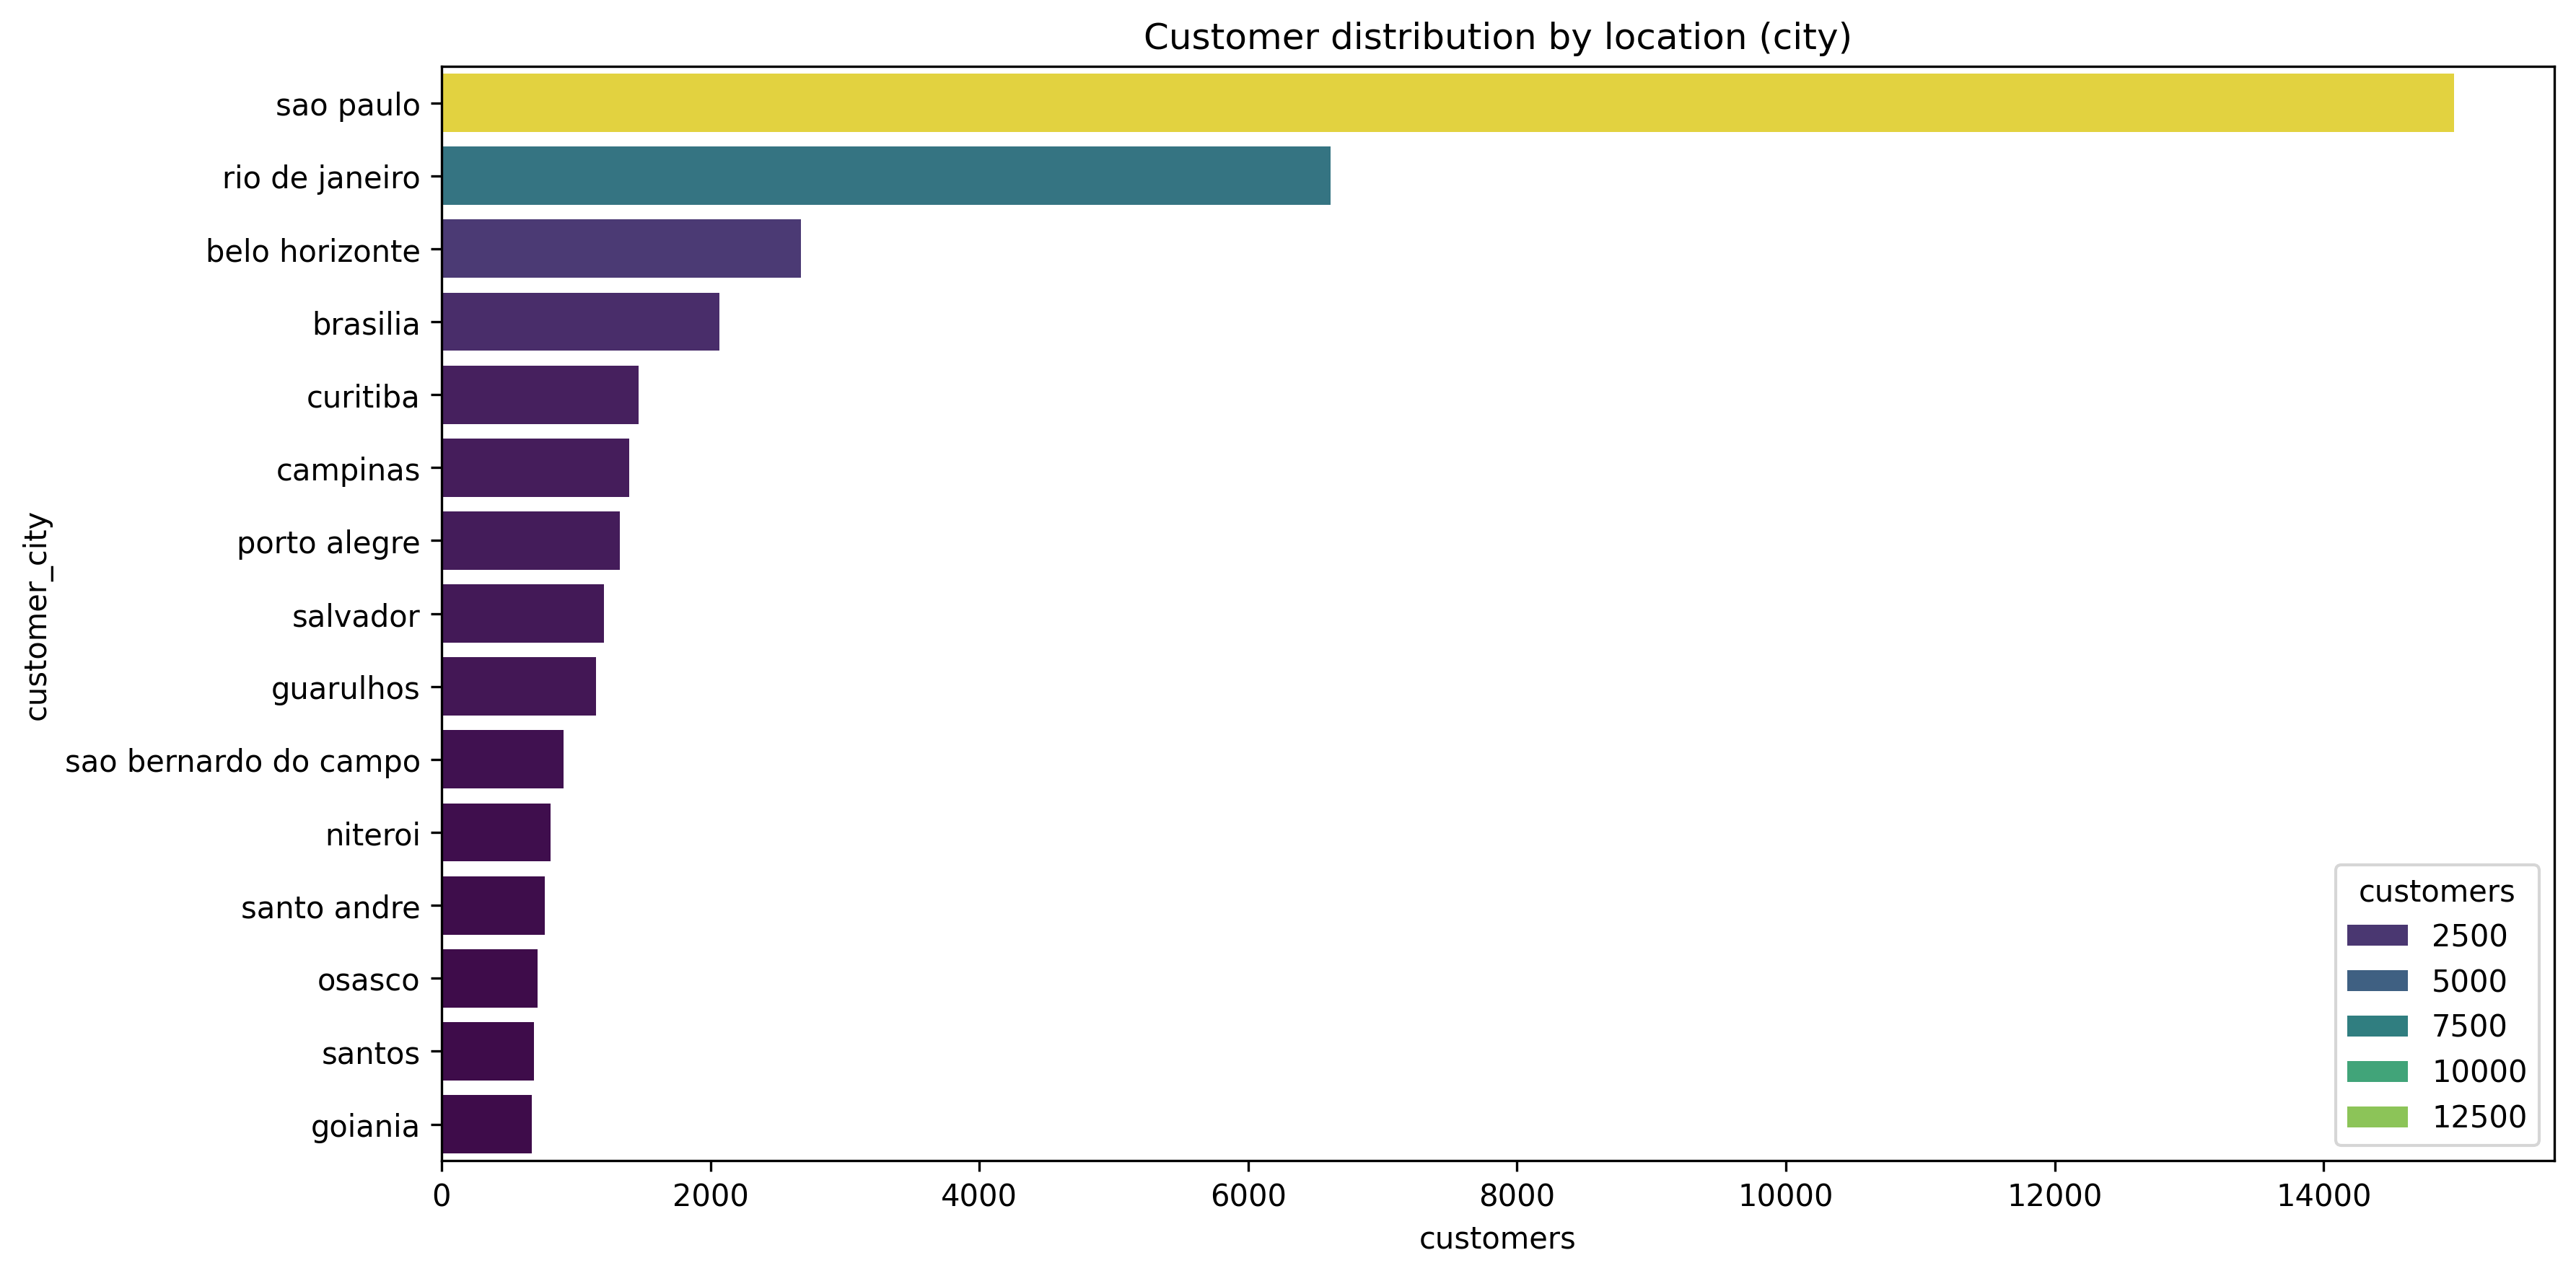

In [37]:
customer_city = orders_customers.groupby("customer_city")["customer_unique_id"].nunique().reset_index(name="customers").sort_values(by = "customers", ascending = False)
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.barplot(data = customer_city.head(15), x = "customers", y = "customer_city",hue = "customers",palette = "viridis")
plt.title("Customer distribution by location (city)")
plt.tight_layout()
plt.savefig("../output/charts/customers_city_distribution.png", dpi = 300)

> As we can see in the chart, the city with the most customers is **sao paulo**

#### By state 

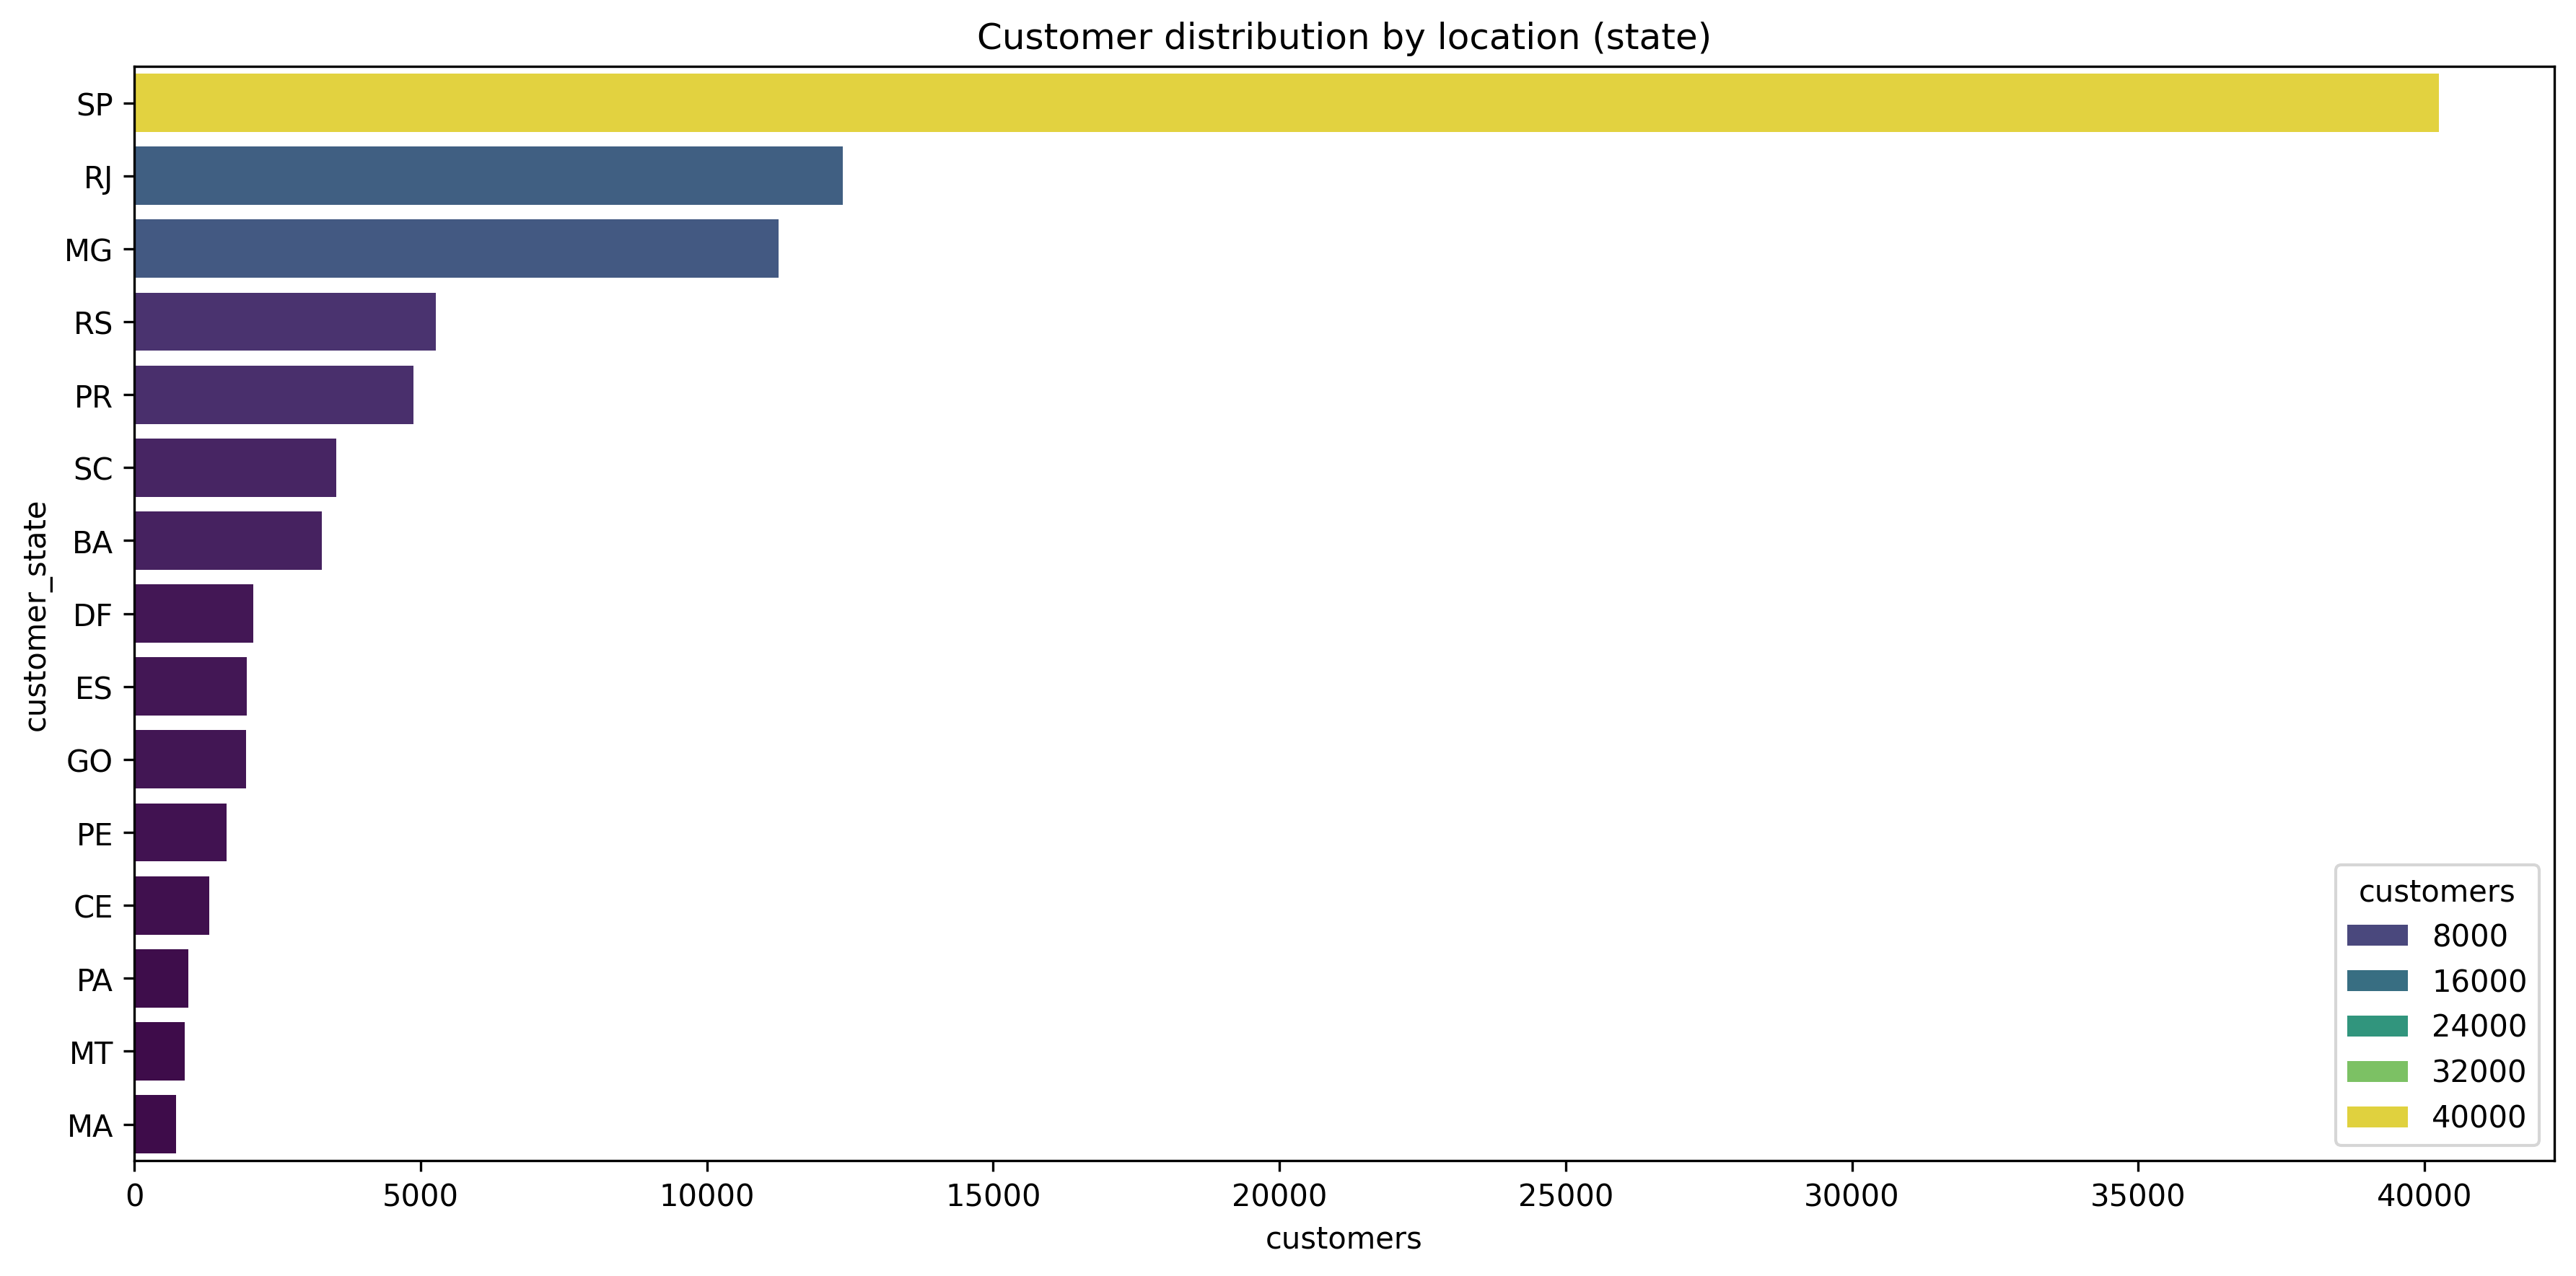

In [38]:
top_states = orders_customers.groupby("customer_state")["customer_unique_id"].nunique().reset_index(name="customers").sort_values(by = "customers", ascending = False)
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.barplot(data = top_states.head(15), x = "customers", y = "customer_state",hue = "customers",palette = "viridis")
plt.title("Customer distribution by location (state)")
plt.tight_layout()
plt.savefig("../output/charts/customers_state_distribution.png", dpi = 300)

> As we can see in the chart, the state with the most customers is **Sao poulo**(SP) with over 40 000 customers

#### Visualizing top 10 products

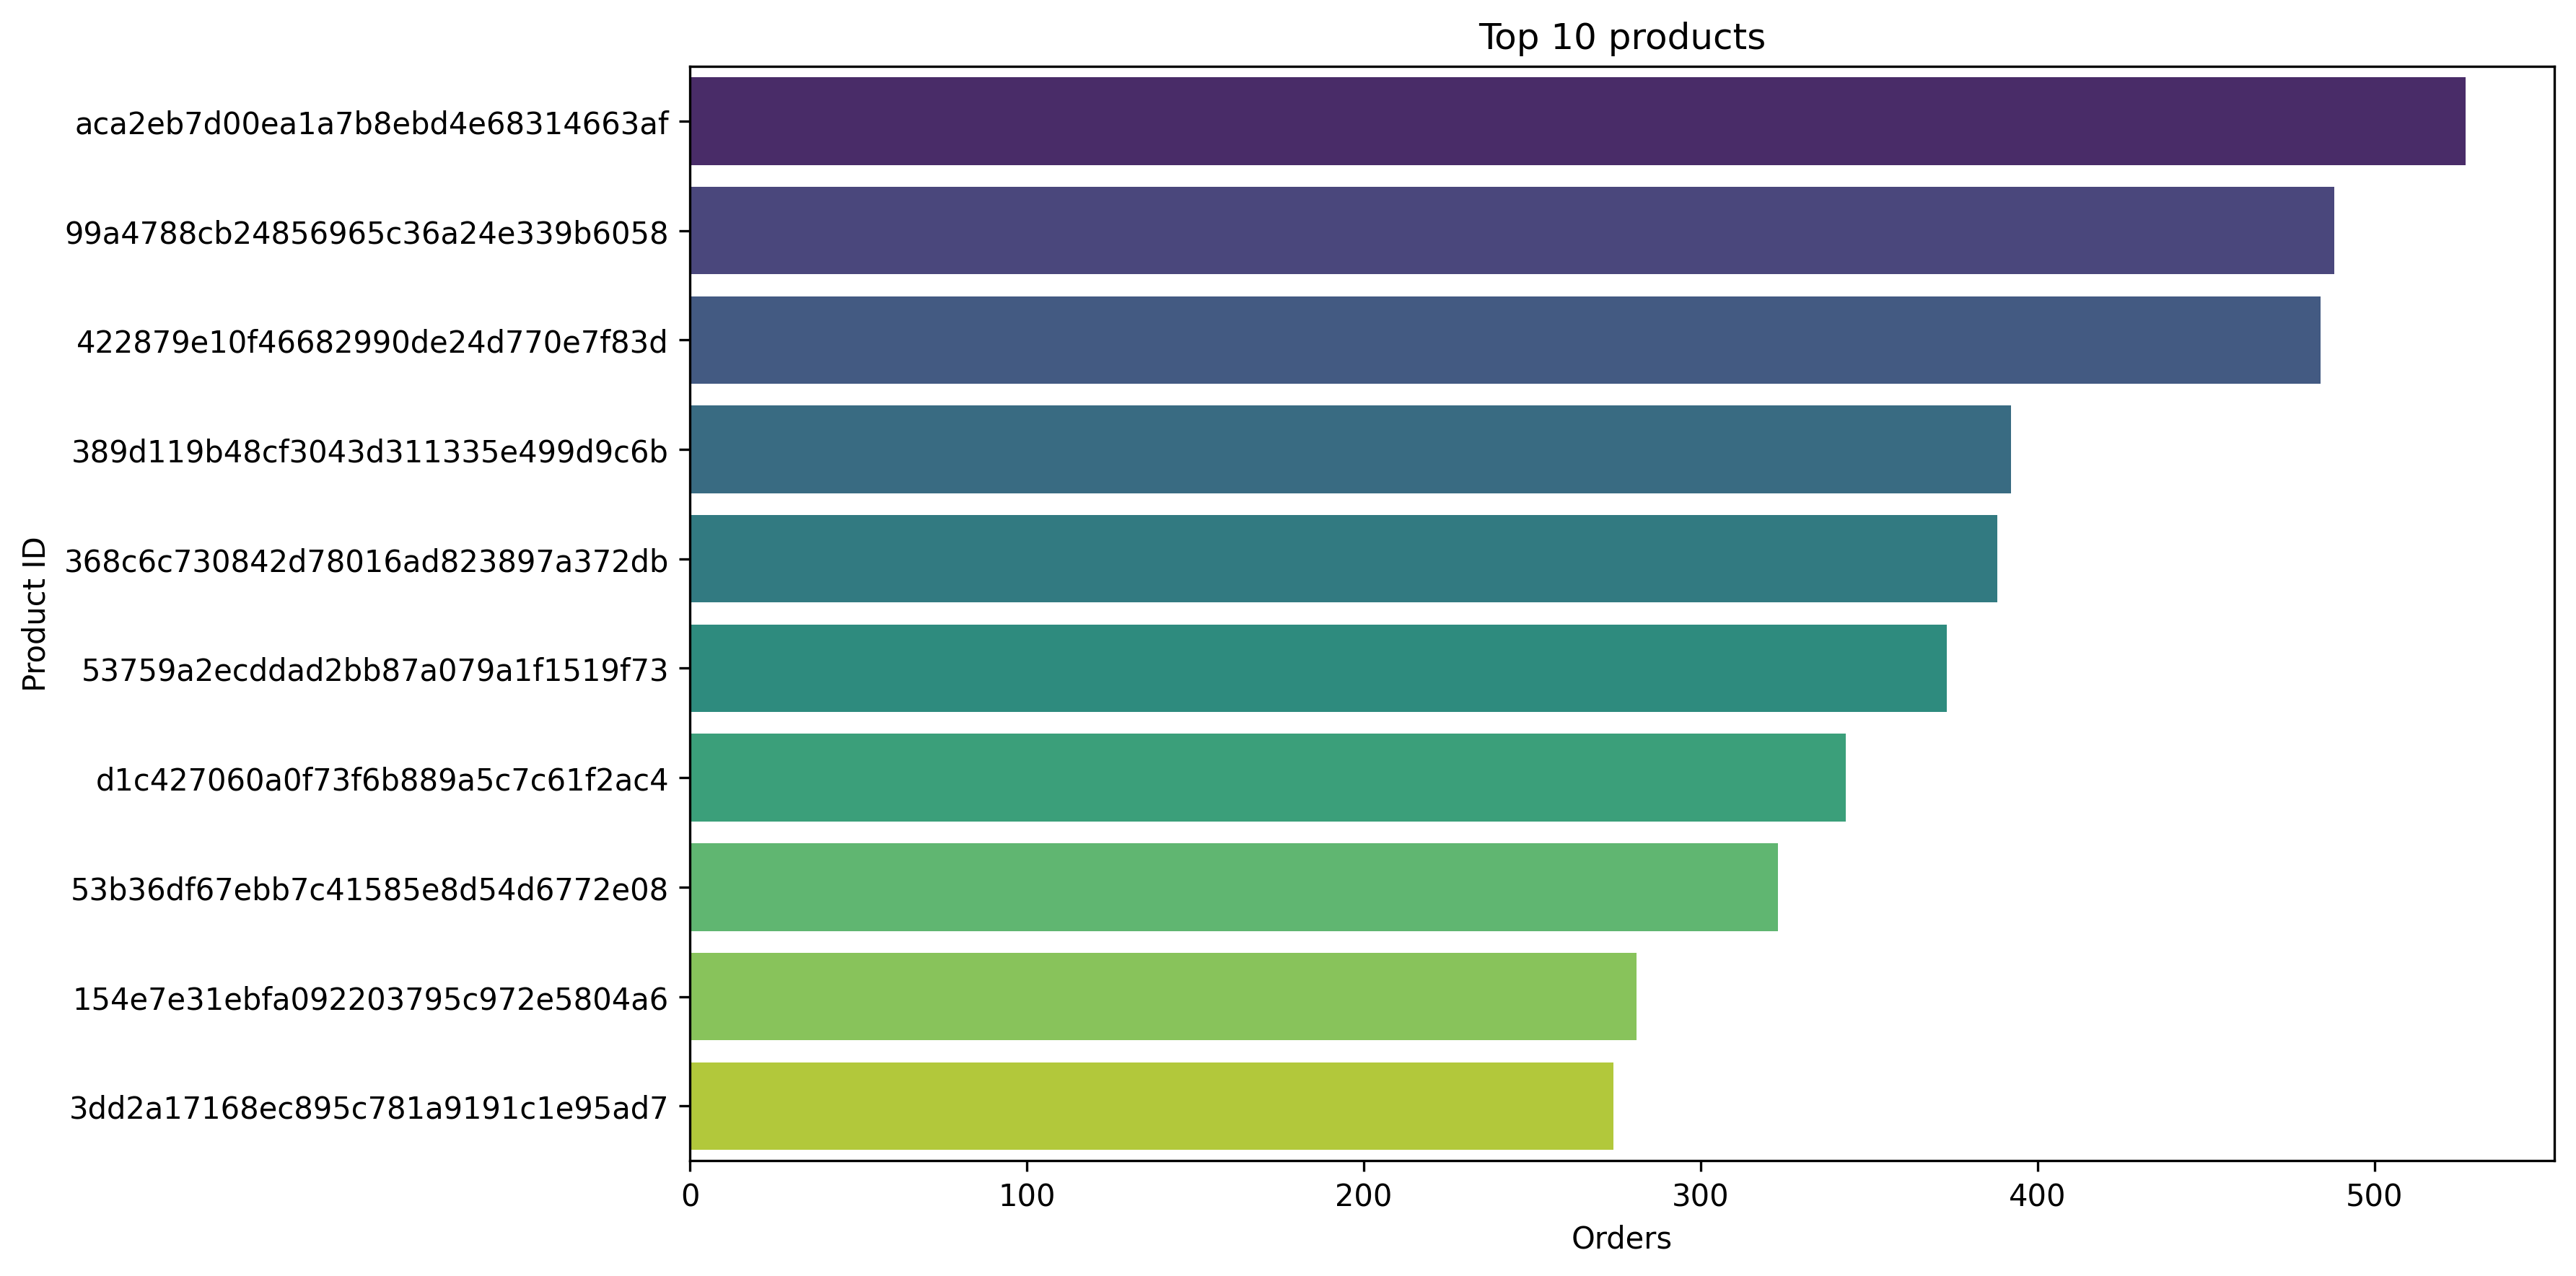

In [39]:
top_products = orders_items.groupby("product_id").size().reset_index(name="orders_count").sort_values(by = "orders_count",ascending = False)
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.barplot(data = top_products.head(10), x = "orders_count", y = "product_id",hue = "product_id",palette = "viridis")
plt.title("Top 10 products")
ax.set_xlabel("Orders")
ax.set_ylabel("Product ID")
plt.tight_layout()
plt.savefig("../output/charts/most_ordered_products.png", dpi = 300)

>the top product with the heighest number of orders is with the id : *aca2eb7d00ea1a7b8ebd4e68314663af*

#### Visualizing sellers with the highest delays

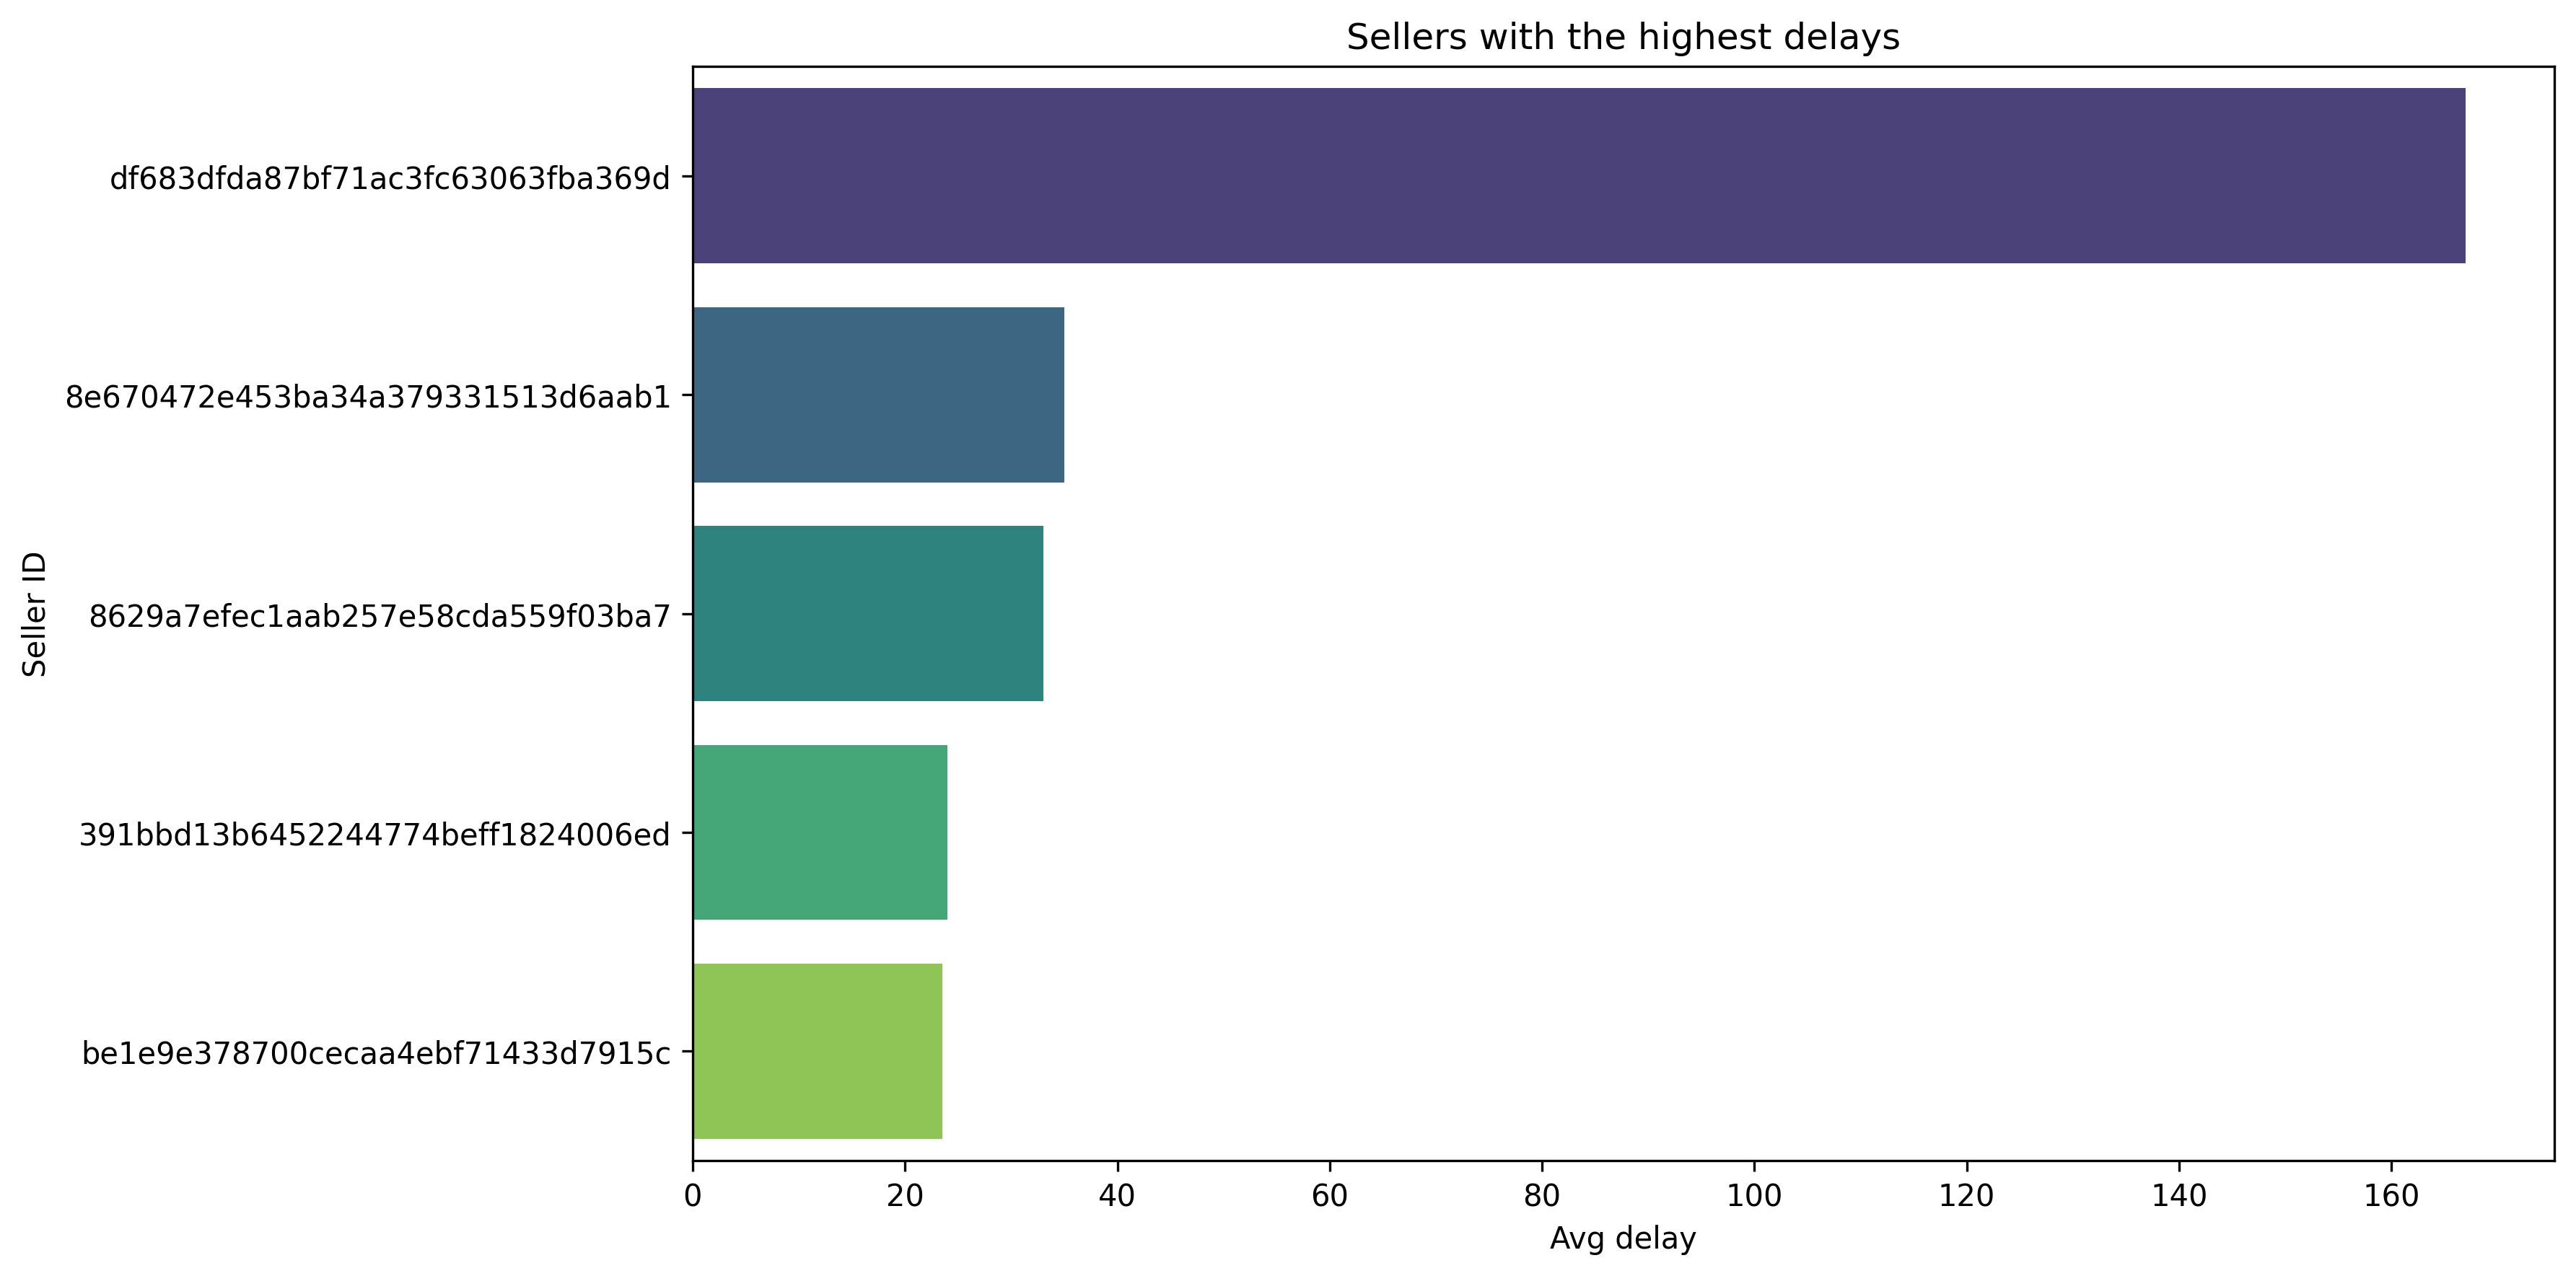

In [40]:
orders_items["delay"] = (orders_items["order_delivered_customer_date"] - orders_items["order_estimated_delivery_date"]).dt.days
top_sellers_by_delay = orders_items.groupby("seller_id")["delay"].median().reset_index(name="avg_delay").sort_values(by="avg_delay",ascending = False)
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.barplot(data = top_sellers_by_delay.head(5), x = "avg_delay", y = "seller_id", hue = "seller_id", palette = "viridis")
plt.title("Sellers with the highest delays")
ax.set_xlabel("Avg delay")
ax.set_ylabel("Seller ID")
plt.tight_layout()
plt.savefig("../output/charts/top_sellers_by_delay.png", dpi = 300)

> The seller with the highest delay is with the id : *df683dfda87bf71ac3fc63063fba369d*	

#### Visualizing the Least ordered products

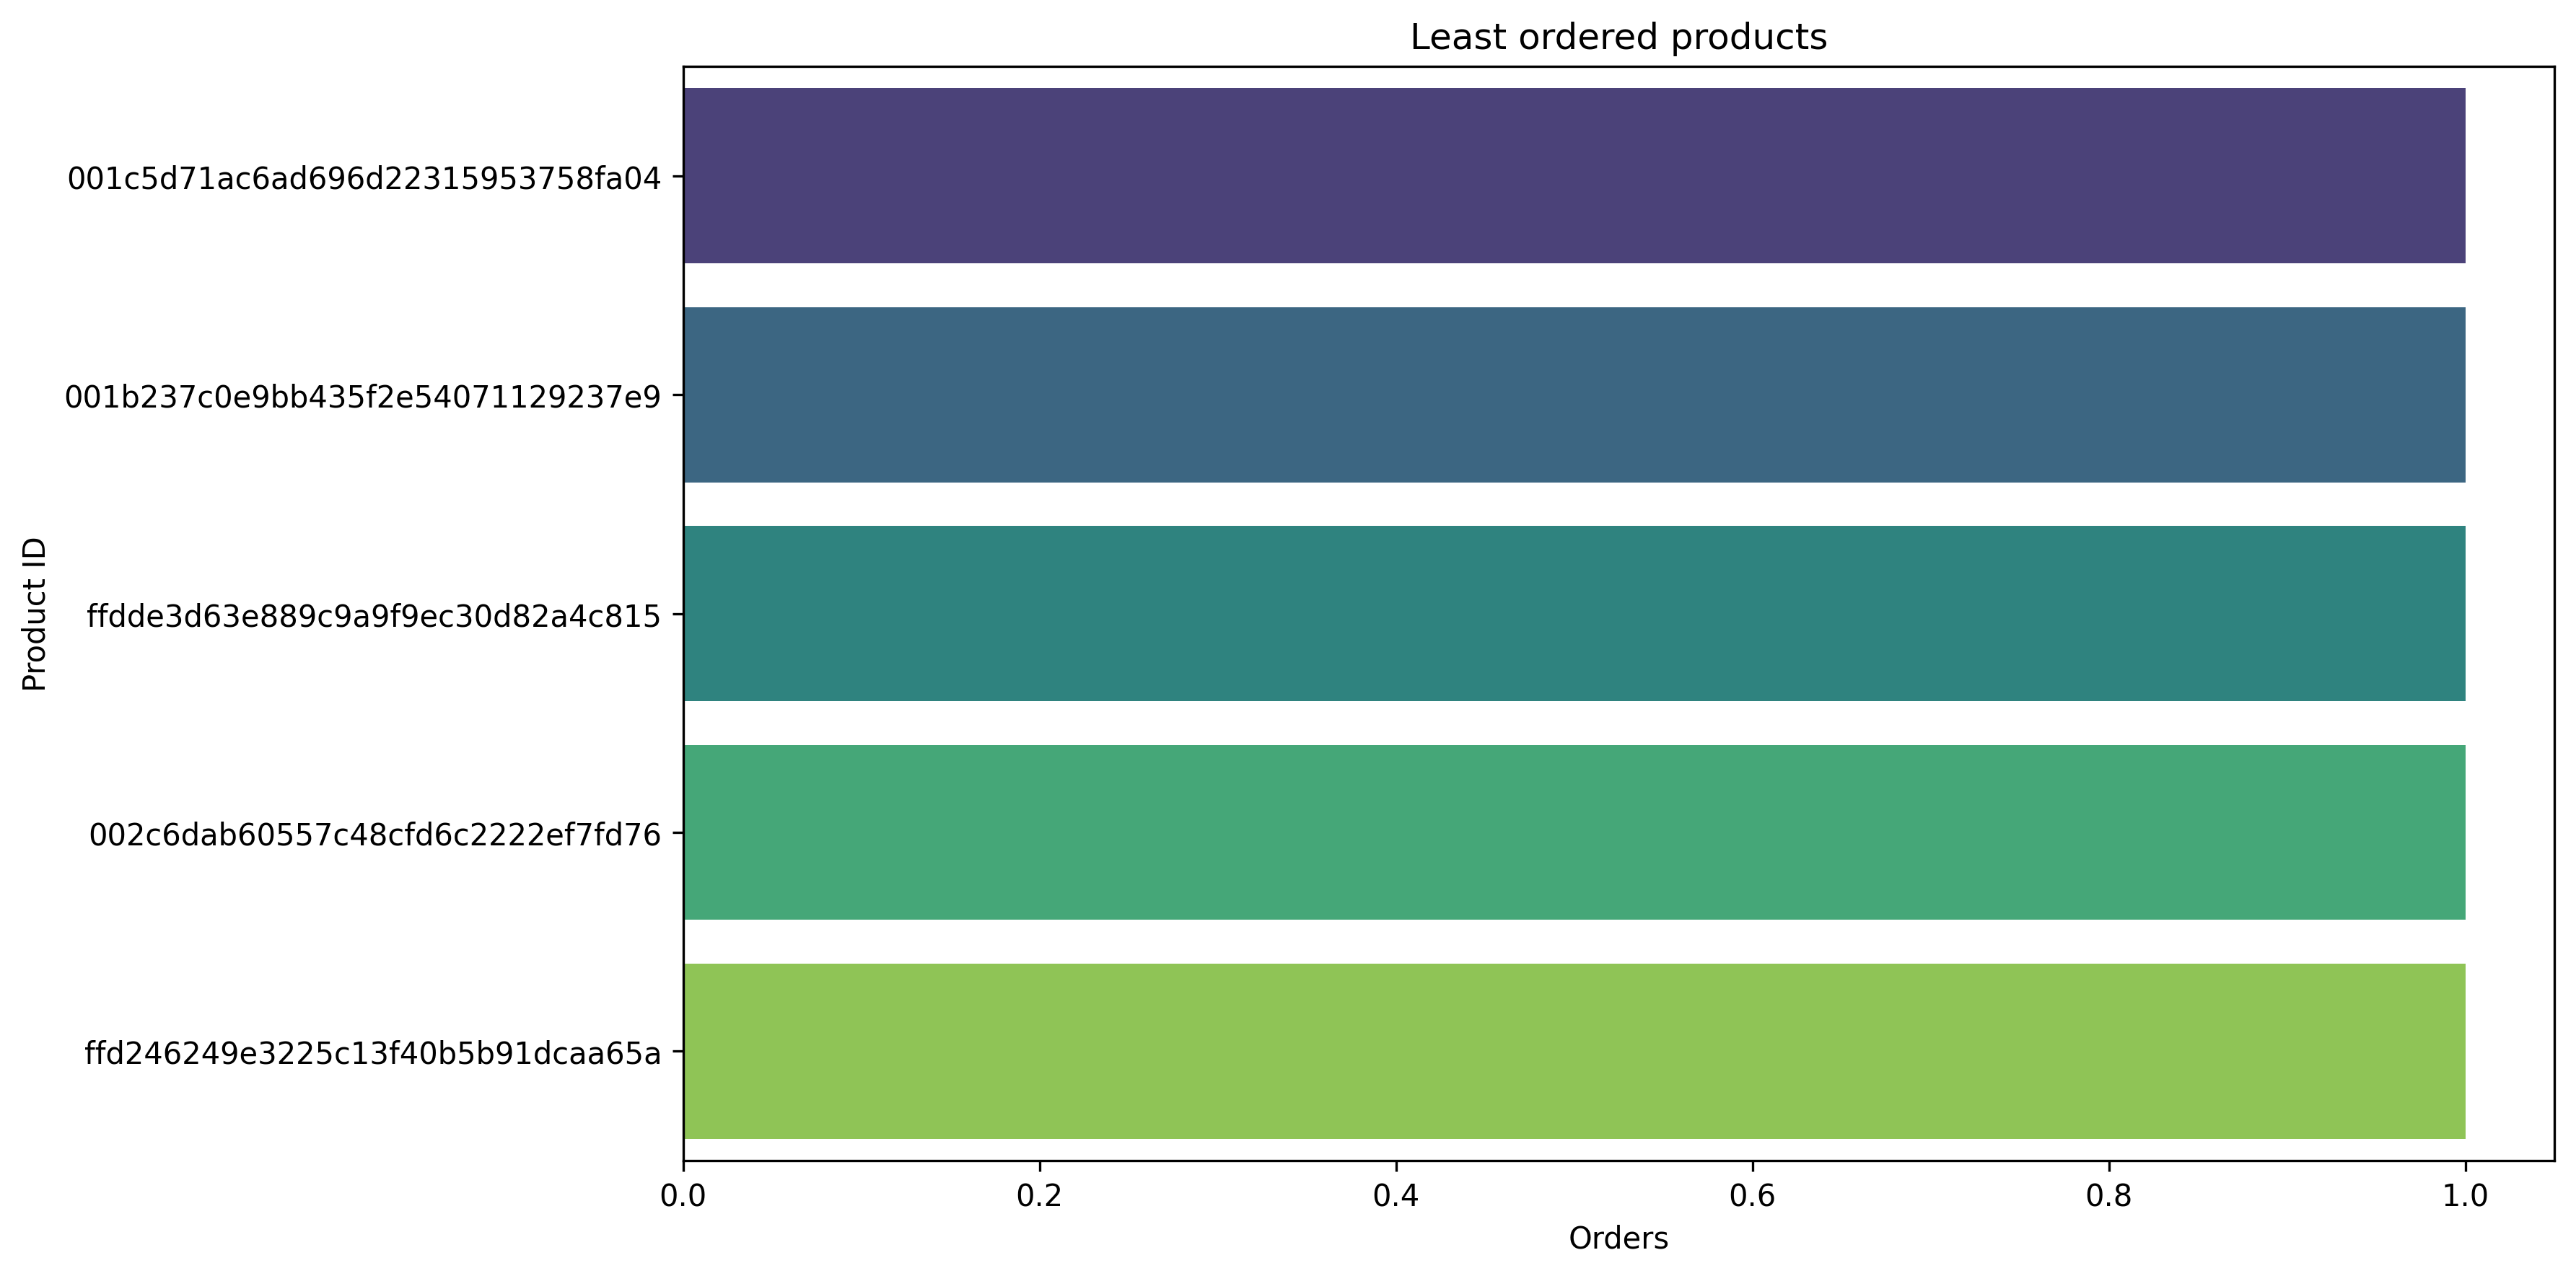

In [41]:
least_ordered_products = orders_items.groupby("product_id").size().reset_index(name="orders_count").sort_values(by="orders_count",ascending = True)
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.barplot(data=least_ordered_products.head(5),x="orders_count",y="product_id",hue="product_id",palette="viridis")
plt.title("Least ordered products")
ax.set_xlabel("Orders")
ax.set_ylabel("Product ID")
plt.tight_layout()
plt.savefig("../output/charts/least_ordered_products.png", dpi = 300)

> As we can see in the chart all the product shown were only ordered once, there's too many products that were only ordred once to display on one chart  

#### Visualizing product price distribution

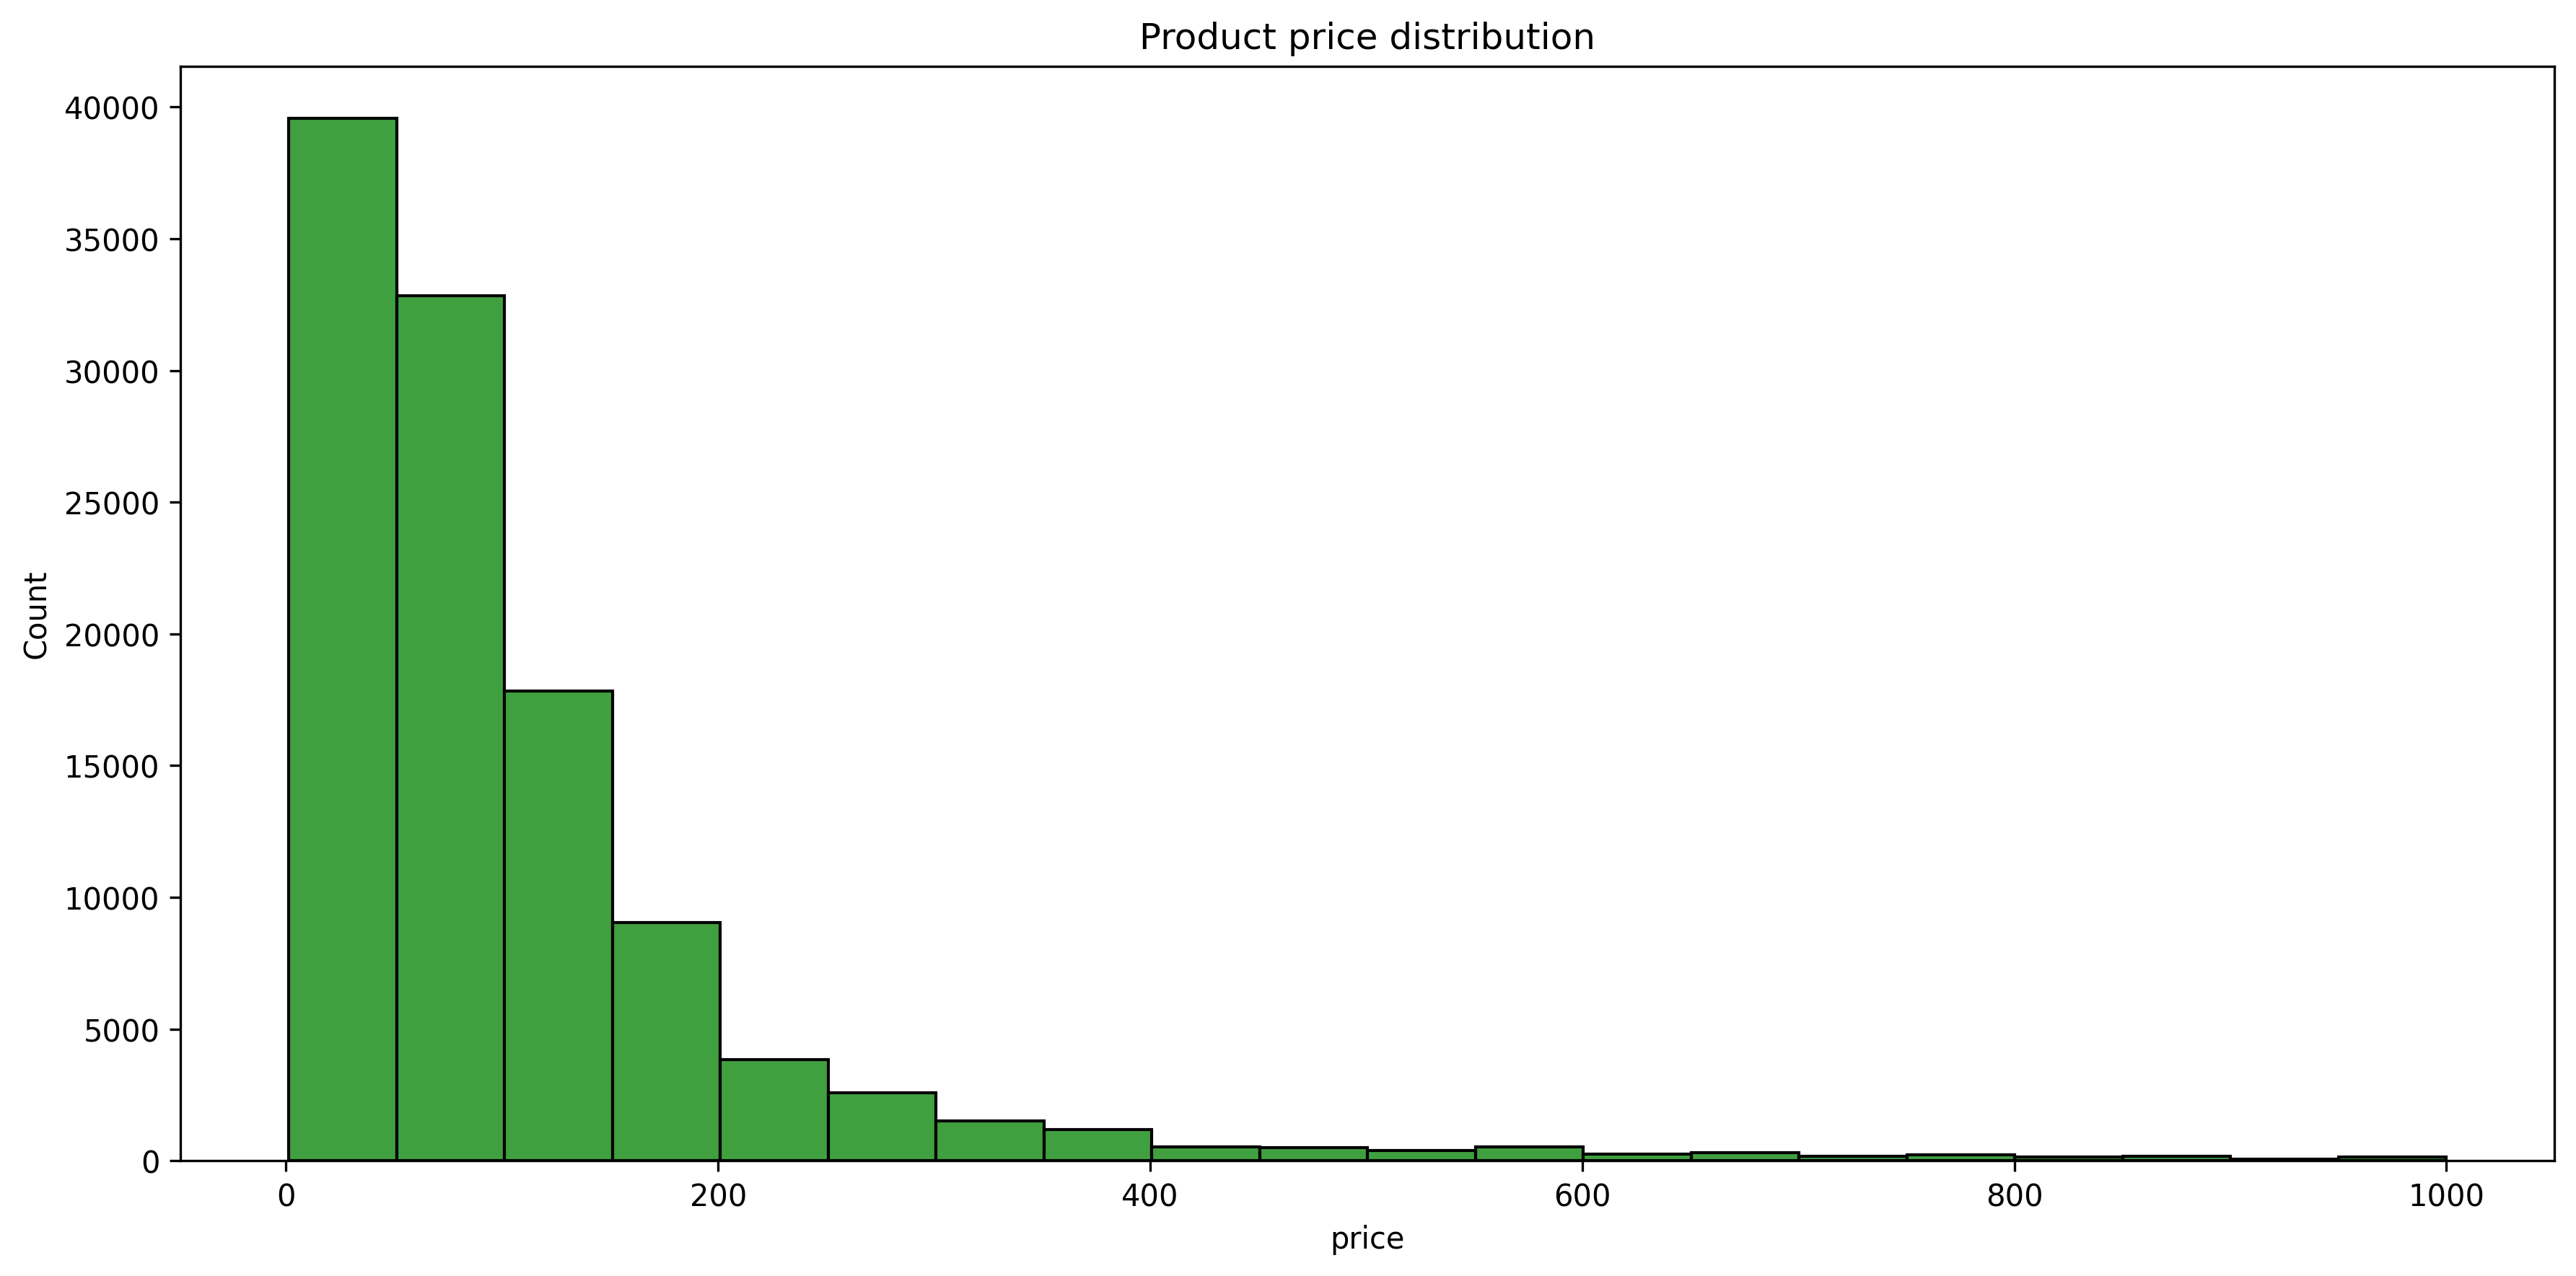

In [42]:
filtered_prices = items["price"][(items["price"] >= 1) & (items["price"] <= 1000)]
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.histplot(filtered_prices,bins = 20,color="green")
plt.title("Product price distribution")
plt.tight_layout()
plt.savefig("../output/charts/least_ordered_products.png", dpi = 300)

> As we can see in the chart, most product prices land between 1 and 200 

#### Visualizing relationship between delivery delay and price  

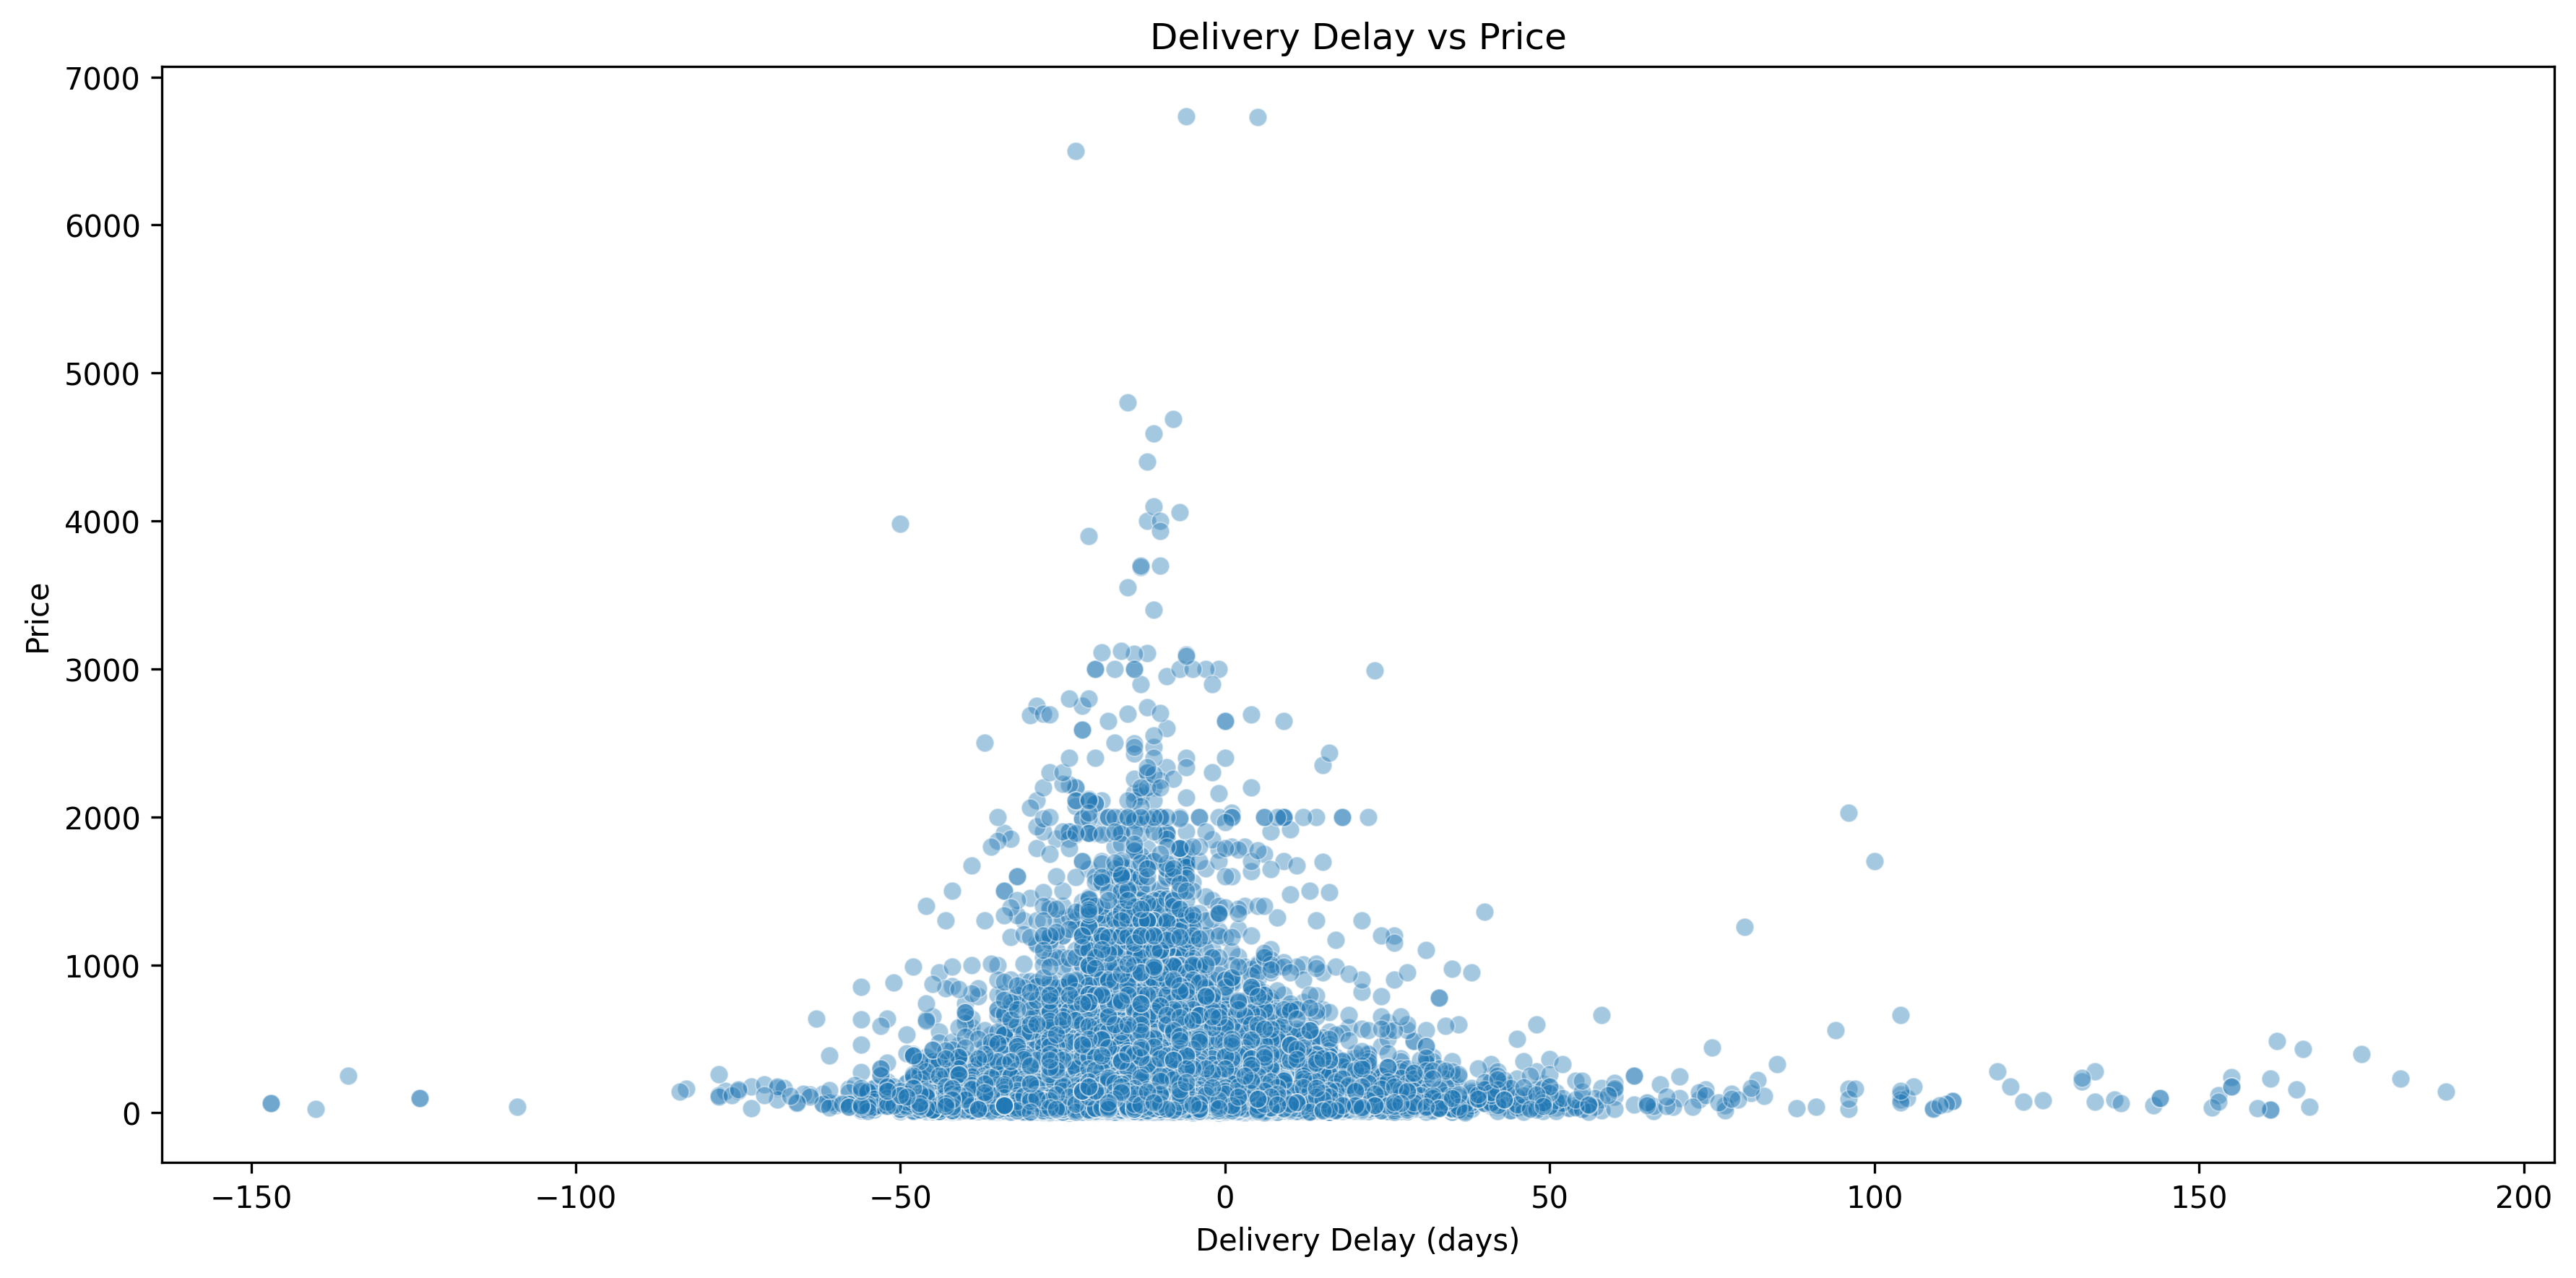

In [43]:
orders_items["delivery_delay"] = (
    orders_items["order_delivered_customer_date"]
    - orders_items["order_estimated_delivery_date"]
).dt.days
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.scatterplot(
    data=orders_items,
    x="delivery_delay",
    y="price",
    alpha=0.4
)

plt.xlabel("Delivery Delay (days)")
plt.ylabel("Price")
plt.title("Delivery Delay vs Price")
plt.tight_layout()
plt.savefig("../output/charts/rls_between_price&delay.png", dpi = 300)

> As we can see in the chart, the price of most deliveries that arrive earlier than excpected land between 0 and 2000

#### Visualizing relationship between order count and revenue

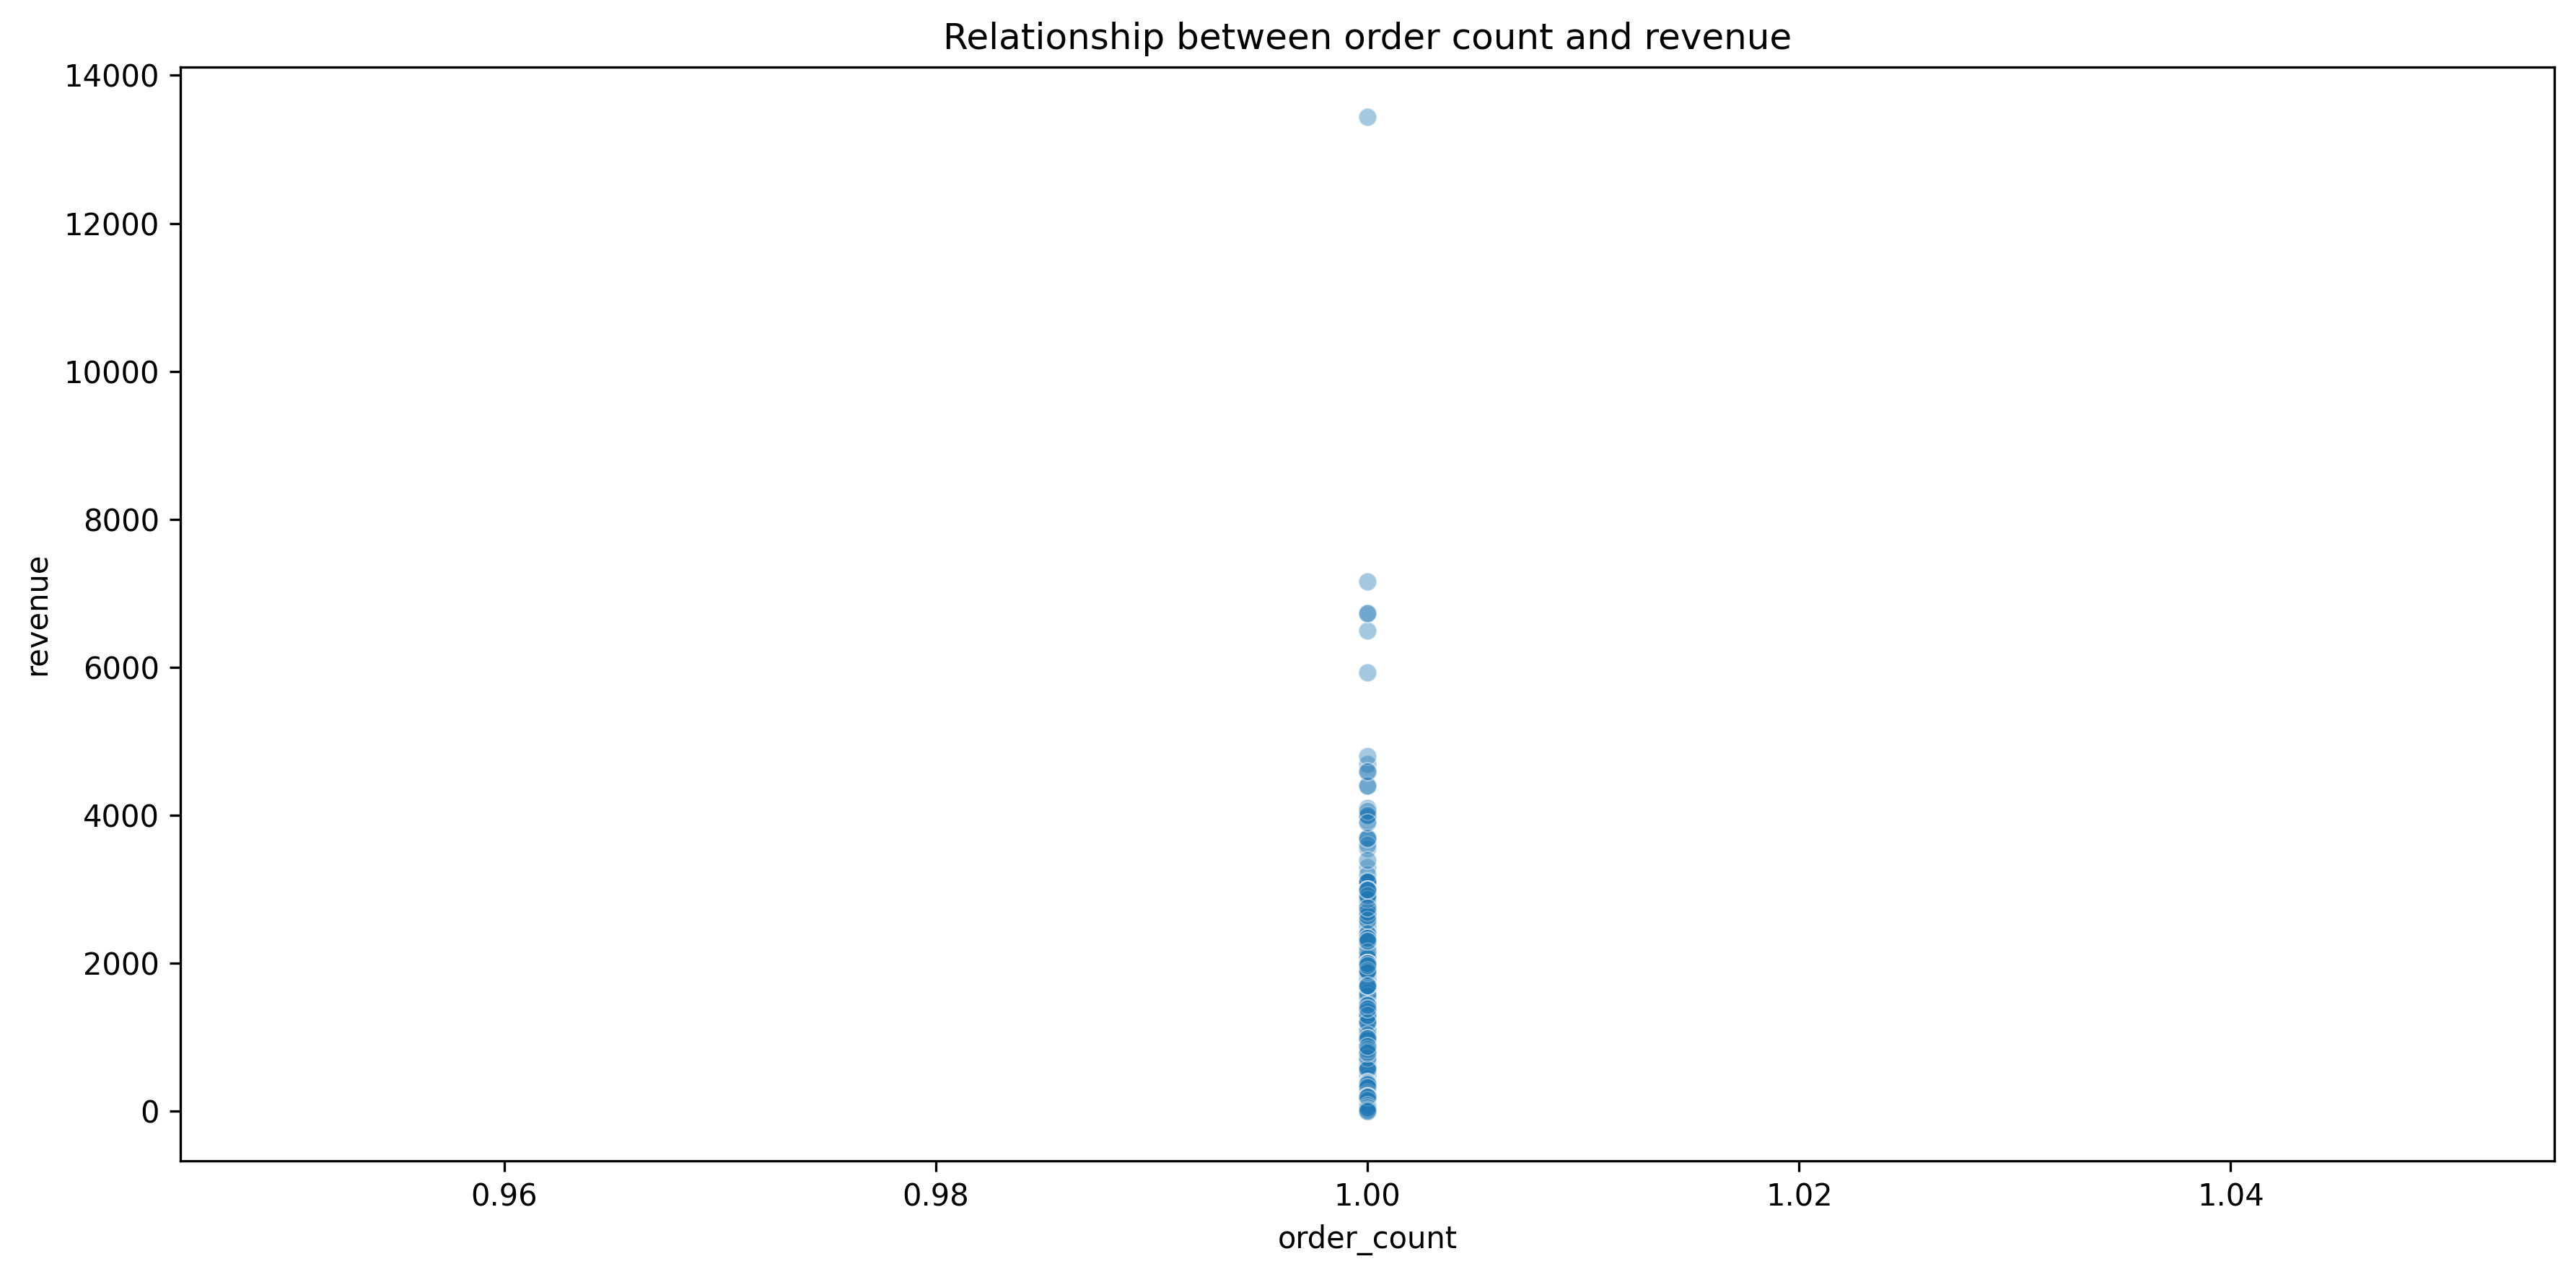

In [44]:
summary = (
    orders_items
    .groupby("customer_id")
    .agg(
        order_count=("order_id", "nunique"),
        revenue=("price", "sum")
    )
    .reset_index()
)
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
sns.scatterplot(
    data=summary,
    x="order_count",
    y="revenue",
    alpha=0.4
)

plt.xlabel("order_count")
plt.ylabel("revenue")
plt.title("Relationship between order count and revenue")
plt.tight_layout()
plt.savefig("../output/charts/rls_between_order_count_and_revenue.png", dpi = 300)

> - As we can see in the chart, almost all customers have a one-time order status
> - Average revenue lands between 0 and 4000